# 3. Modeling

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib 
import pickle

import tensorflow as tf
from keras.layers import *
from keras.regularizers import *
from keras.optimizers import *
from keras.models import *
from keras.preprocessing.text import *
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image

import random
import os
random.seed(42)

In [8]:
# new_df = pd.read_csv(os.path.join("..","..","data",'YN_final_df.csv'))
# new_df.head()
new_df = pd.read_csv(os.path.join("..","..","data",'YN_final_df2.csv'))
new_df.head()

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,rating,locationId,photonum,createdDate,is_fch,is_local,place.name,userID,average_photonum,average_rating,user_mean_rating,user_reviewcount,lat,lng,land.addr,category,rated_count,category_l
0,4.5,1150710065,0,2020-05-21 20:42:00,1,1,스타벅스 보라매공원R점,432293,0.164557,4.506329,4.5,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1
1,5.0,1150710065,0,2019-06-28 01:11:03,1,1,스타벅스 보라매공원R점,135109,0.164557,4.506329,5.0,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1
2,5.0,1150710065,0,2020-03-12 00:22:00,1,1,스타벅스 보라매공원R점,269138,0.164557,4.506329,5.0,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1
3,5.0,1150710065,0,2020-02-16 17:06:00,1,1,스타벅스 보라매공원R점,246123,0.164557,4.506329,5.0,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1
4,5.0,1150710065,0,2019-03-11 00:08:48,1,1,스타벅스 보라매공원R점,119248,0.164557,4.506329,5.0,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1


### 로컬 / 글로벌 데이터 분리

In [9]:
# 로컬 / 글로벌 데이터 분리
local_df = new_df.loc[new_df['is_local']==1]
global_df = new_df.loc[new_df['is_local']==0]
print('local_df shape:',local_df.shape, 'global_df shape :',global_df.shape)

local_df shape: (381125, 18) global_df shape : (98566, 18)


In [46]:
# 로컬, 글로벌 공통 location id 뽑기
local_id = local_df['locationId'].unique().tolist()
global_id = global_df['locationId'].unique().tolist()

common_ids = []
for i in local_id:
    if i in global_id:
        common_ids.append(i)

common_acm = new_df.loc[new_df['locationId'].isin(common_ids)]
common_acm = common_acm.loc[common_acm['category']=='ACM']
common_acm_ids = common_acm['locationId'].unique().tolist()
# global, local 모두 담은 acm location ids
print(len(common_acm_ids)) 

240


In [10]:
def get_data(column, df) :
    
    vocab = {}
    num = 0

    for i in df[column]: 
        if vocab.get(i) != None:
            continue

        vocab[i] = num
        num += 1

    encoded = [vocab[i] for i in df[column]]
    
    return encoded, num, vocab

In [11]:
def trans_mul(vects):
    z = tf.reshape(vects,(-1,n_factors,1))
    return z 

def concat_shape2D(vects):
    a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11 = vects 
    z = tf.concat([a1,a2],axis=2)
    z = tf.concat([z,a3],axis=2)
    z = tf.concat([z,a4],axis=2)
    z = tf.concat([z,a5],axis=2)
    z = tf.concat([z,a6],axis=2)
    z = tf.concat([z,a7],axis=2)
    z = tf.concat([z,a8],axis=2)
    z = tf.concat([z,a9],axis=2)
    z = tf.concat([z,a10],axis=2)
    z = tf.concat([z,a11],axis=2)
    return z

def sum_layer(vects):
    a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11 = vects
    z = tf.add(a1,a2)
    z = tf.add(z,a3) 
    z = tf.add(z,a4)
    z = tf.add(z,a5)
    z = tf.add(z,a6)
    z = tf.add(z,a7)
    z = tf.add(z,a8)
    z = tf.add(z,a9)
    z = tf.add(z,a10)
    z = tf.add(z,a11)
    return z 

## 1. local_modeling

In [12]:
local_df_acm = local_df.loc[local_df['category'] == 'ACM']
local_df_eat = local_df.loc[local_df['category'] == 'EAT']

# 평균평점 이상의 식당만 남김.
local_df_eat = local_df_eat.loc[local_df_eat['average_rating']>=local_df_eat['average_rating'].median()]
local_df = pd.concat([local_df_acm, local_df_eat])

# local이기에 global과 차이를 두기위해 최대한 의미없는 체인 제거 
local_df = local_df.loc[local_df['is_fch']==0]

# 의미없는 추천 식당 제거 
fch_lst = ['써브웨이', '던킨도너츠','노브랜드버거','바르다김선생',' 폴바셋',' 안동찜닭',' 속초코다리냉면',' 할매순대국&양선지해장국',' 노브랜드버거 남부터미널점','바르다김선생' ,'유가네','24시 중식당 취빈','매머드커피','압구정봉구비어','카페베네','쥬씨','피자스쿨','매머드익스프레스','김밥천국','한국맥도날드','메머드커피','신전떡볶이','어사또', '공차', '북촌손만두', '오징어세상' ,'사월에보리밥', '땡스브레드엔커피', '피자몰', '나주소나주곰탕', '새마을식당','싸다김밥', '교동짬뽕', '토마토김밥', '화화쿵주마라탕', '샐러데이즈', '더차이','뚜레쥬르','스쿨푸드','자연별곡','죠스떡볶이','국대떡볶이', '도쿄스테이크','이디야커피', '코스트코코리아양재점푸드코트', '불고기브라더스','알라딘중고서점카페','배스킨라빈스','할리스커피', '와플대학', '파리바게뜨공덕역사', '파리바게뜨','아웃백','설빙', '봉추찜닭', '하겐다즈','아라마크연세의료원종합관'
]
fch_idx = local_df[local_df['place.name'].apply(lambda x: any(i in x for i in fch_lst))].index.tolist()
idx = local_df[local_df['place.name'].apply(lambda x: x[-1] == '점')].index.tolist()

for i in idx:
    if i not in fch_idx:
        fch_idx.append(i)

local_df = local_df.drop(fch_idx)
print('의미없을만한 식당 제거 후 local데이터 크기:',local_df.shape)

의미없을만한 식당 제거 후 local데이터 크기: (95266, 18)


In [13]:
local_df.to_csv(os.path.join("..","realtime_model",'local_df(wnd)2.csv'), index=False)

In [14]:
encoded_userID, num_userID, vocab_userID = get_data('userID', local_df) 
encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', local_df) 
encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', local_df) 
encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', local_df) 
encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', local_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', local_df) 
encoded_fch,  num_fch, vocab_fch = get_data('is_fch', local_df) 
encoded_category_l,  num_category_l, vocab_category_l = get_data('category_l', local_df) 
encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', local_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', local_df) 
encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', local_df) 


# Input Data

In [15]:
n_factors = 8 
layers = [16,8, 4] 

# Input variables
userID = Input(shape=(1,), dtype='int64', name = 'userID') 
users_mean_rating = Input(shape=(1,), dtype='int64', name = 'users_mean_rating') 
user_reviewcount = Input(shape=(1,), dtype='int64', name = 'user_reviewcount') 
locationId = Input(shape=(1,), dtype='int64', name = 'locationId')
placeType = Input(shape=(1,), dtype='int64', name = 'placeType')
createdDate = Input(shape=(1,), dtype='int64', name = 'createdDate')
photonum = Input(shape=(1,), dtype='int64', name = 'photonum')
fch = Input(shape=(1,), dtype='int64', name = 'fch')
category_l = Input(shape=(1,), dtype='int64', name = 'category_l')
rated_count = Input(shape=(1,), dtype='int64', name = 'rated_count')
average_photonum = Input(shape=(1,), dtype='int64', name = 'average_photonum')
average_rating = Input(shape=(1,), dtype='int64', name = 'average_rating')

In [16]:
FM_userID = Embedding(input_dim = num_userID, output_dim = n_factors, 
                              name = 'FM_userID', input_length=1)(userID)
FM_users_mean_rating = Embedding(input_dim = num_users_mean_rating, output_dim = n_factors,
                              name = 'FM_users_mean_rating', input_length=1)(users_mean_rating)  
FM_user_reviewcount = Embedding(input_dim = num_user_reviewcount, output_dim = n_factors, 
                              name = 'FM_user_reviewcount', input_length=1)(user_reviewcount)
FM_locationId= Embedding(input_dim = num_locationId, output_dim = n_factors,
                              name = 'FM_locationId', input_length=1)(locationId)   
FM_createdDate = Embedding(input_dim = num_createdDate, output_dim = n_factors, 
                              name = 'FM_createdDate', input_length=1)(createdDate)
FM_photonum = Embedding(input_dim = num_photonum, output_dim = n_factors, 
                              name = 'FM_photonum', input_length=1)(photonum)
FM_fch = Embedding(input_dim = num_fch, output_dim = n_factors, 
                              name = 'FM_fch', input_length=1)(fch)
FM_category_l = Embedding(input_dim = num_category_l, output_dim = n_factors, 
                              name = 'FM_category_l', input_length=1)(category_l)
FM_rated_count = Embedding(input_dim = num_rated_count, output_dim = n_factors, 
                              name = 'FM_rated_count', input_length=1)(rated_count)
FM_average_photonum = Embedding(input_dim = num_average_photonum, output_dim = n_factors, 
                              name = 'FM_average_photonum', input_length=1)(average_photonum)
FM_average_rating = Embedding(input_dim = num_average_rating, output_dim = n_factors, 
                              name = 'FM_average_rating', input_length=1)(average_rating)

In [17]:
FM_userID_latent = Flatten()(FM_userID)
FM_userID_latent = Lambda(trans_mul)(FM_userID_latent)

FM_users_mean_rating_latent = Flatten()(FM_users_mean_rating)
FM_users_mean_rating_latent = Lambda(trans_mul)(FM_users_mean_rating_latent)

FM_user_reviewcount_latent = Flatten()(FM_user_reviewcount)
FM_user_reviewcount_latent = Lambda(trans_mul)(FM_user_reviewcount_latent)

FM_locationId_latent = Flatten()(FM_locationId)
FM_locationId_latent = Lambda(trans_mul)(FM_locationId_latent)

FM_createdDate_latent = Flatten()(FM_createdDate)
FM_createdDate_latent = Lambda(trans_mul)(FM_createdDate_latent)

FM_photonum_latent = Flatten()(FM_photonum)
FM_photonum_latent = Lambda(trans_mul)(FM_photonum_latent)

FM_fch_latent = Flatten()(FM_fch)
FM_fch_latent = Lambda(trans_mul)(FM_fch_latent)

FM_category_l_latent = Flatten()(FM_category_l)
FM_category_l_latent = Lambda(trans_mul)(FM_category_l_latent)

FM_rated_count_latent = Flatten()(FM_rated_count)
FM_rated_count_latent = Lambda(trans_mul)(FM_rated_count_latent)

FM_average_photonum_latent = Flatten()(FM_average_photonum)
FM_average_photonum_latent = Lambda(trans_mul)(FM_average_photonum_latent)

FM_average_rating_latent = Flatten()(FM_average_rating)
FM_average_rating_latent = Lambda(trans_mul)(FM_average_rating_latent)


FM_conv1d =Lambda(concat_shape2D)([FM_userID_latent, FM_users_mean_rating_latent,
                             FM_user_reviewcount_latent, FM_locationId_latent,
                             FM_createdDate_latent, FM_photonum_latent,
                                  FM_fch_latent, FM_category_l_latent, FM_rated_count_latent,
                                  FM_average_photonum_latent, FM_average_rating_latent])


MF_part = Conv1D(128,kernel_size=1,activation='relu')(FM_conv1d)
MF_part = Flatten()(MF_part)

In [18]:
mlp_concat = Concatenate()([FM_userID_latent, FM_users_mean_rating_latent,
                             FM_user_reviewcount_latent, FM_locationId_latent,
                             FM_createdDate_latent, FM_photonum_latent,
                                  FM_fch_latent, FM_category_l_latent, FM_rated_count_latent,
                                  FM_average_photonum_latent, FM_average_rating_latent])
mlp_concat = Flatten()(mlp_concat)

mlp_concat1 = Dense(layers[0], activation='relu', name=f"layer{0}")(mlp_concat) 
mlp_concat1 = Dense(layers[1], activation='relu', name=f"layer{1}")(mlp_concat1)
mlp_concat = Concatenate()([mlp_concat,mlp_concat1])
mlp_concat = Dense(layers[2],activation='relu')(mlp_concat)

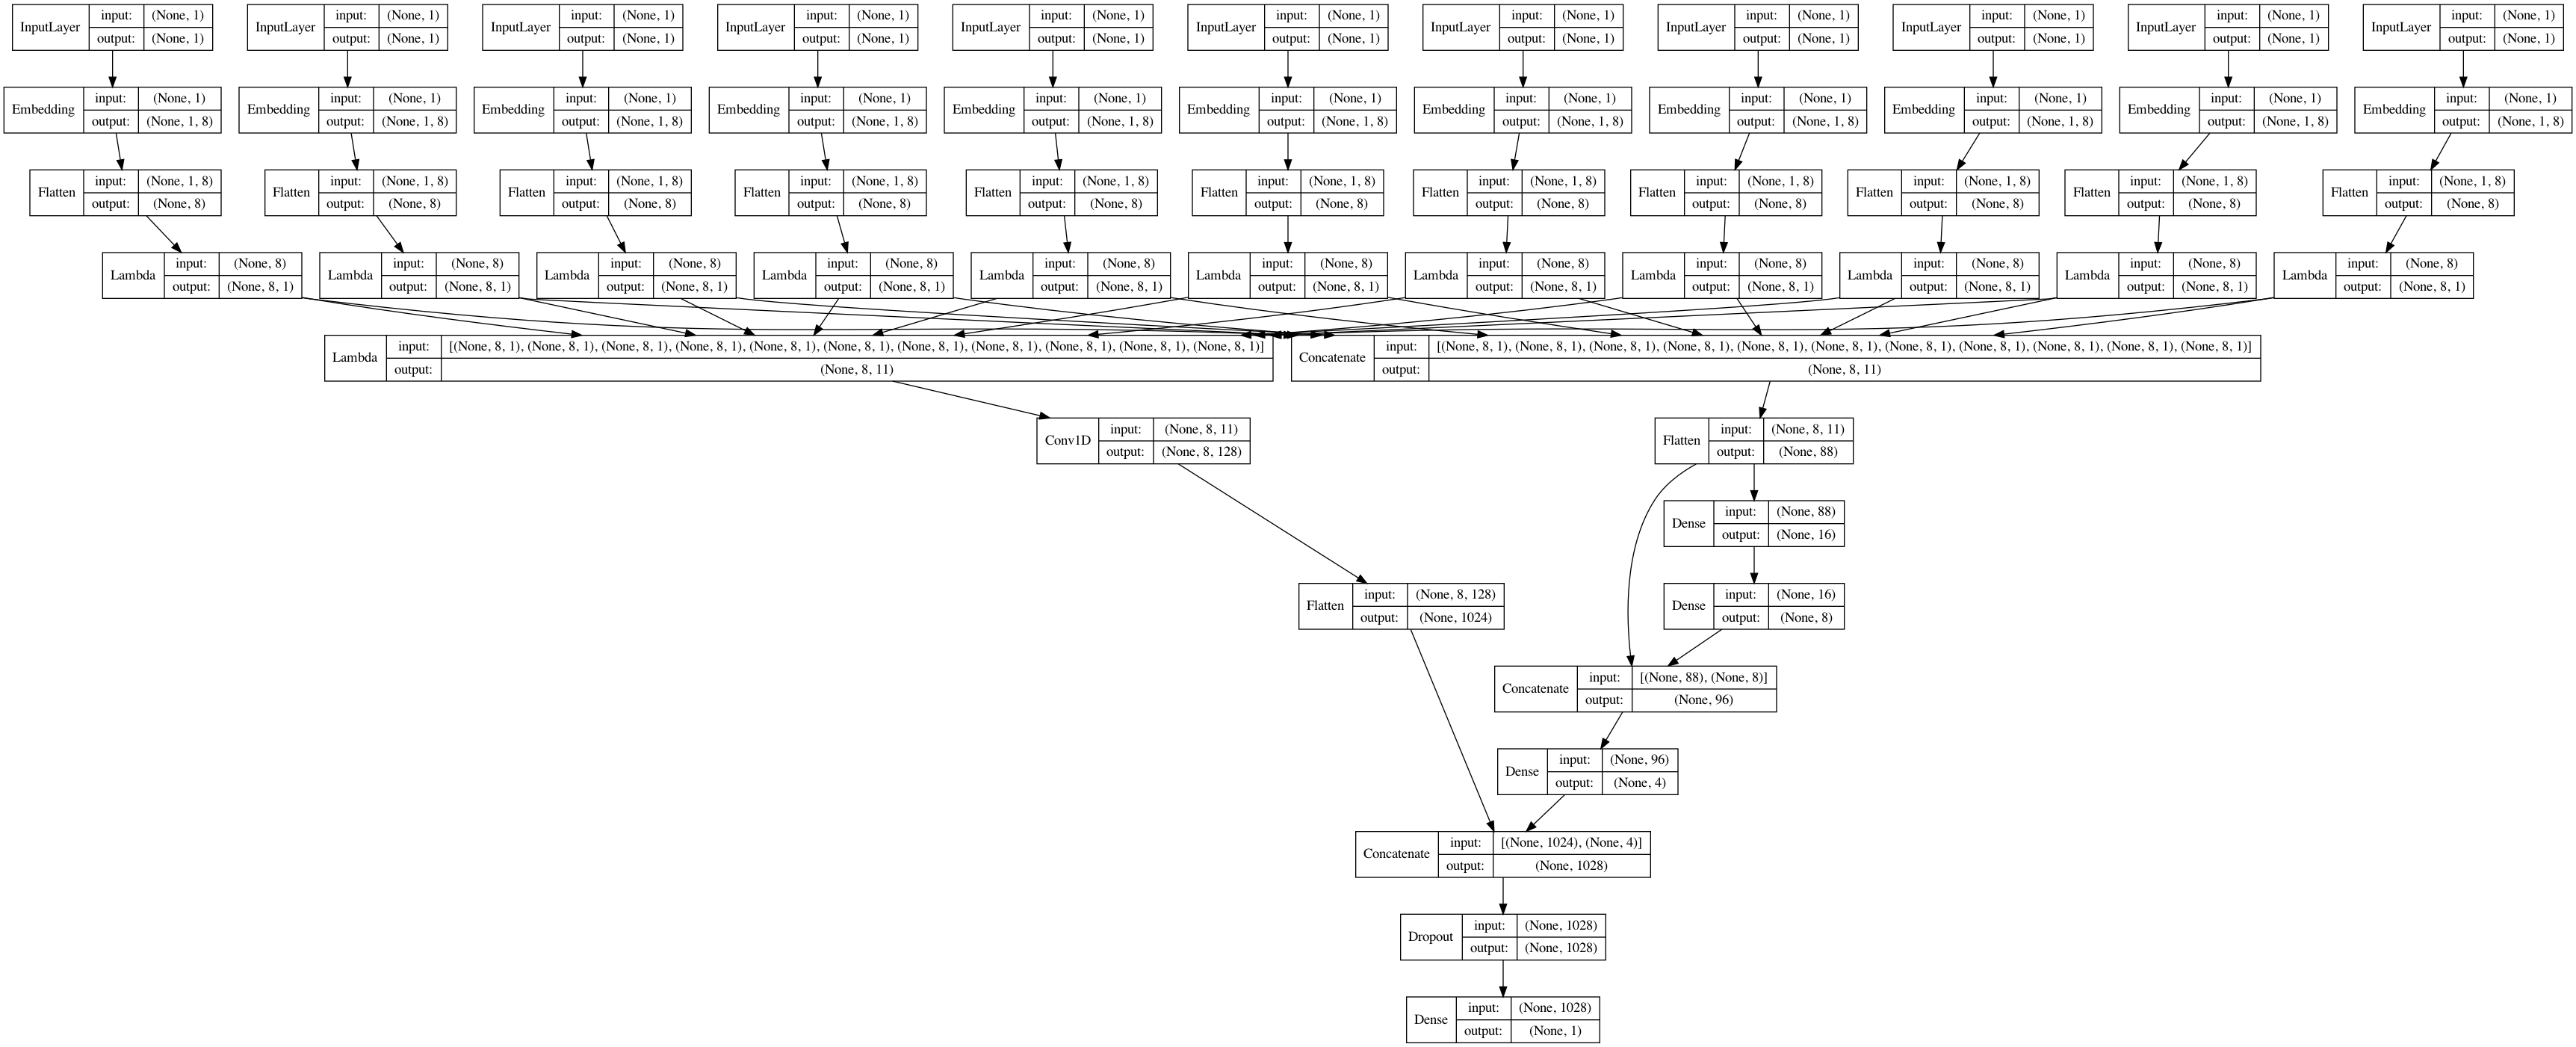

In [19]:
# Concatenate MF and MLP parts
predict_vector = Concatenate()([MF_part, mlp_concat])
predict_vector = Dropout(0.2)(predict_vector)

# Final prediction layer
prediction = Dense(1, name = "prediction")(predict_vector) # activation='sigmoid',
model = Model([userID, users_mean_rating, 
                             user_reviewcount, locationId, 
                             createdDate, photonum, fch, category_l, rated_count,
                                  average_photonum, average_rating], prediction)
model.compile(loss="mse", optimizer=RMSprop(lr=1e-4), metrics=[tf.keras.metrics.AUC()])

Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 94789 samples, validate on 477 samples
Epoch 1/20
94789/94789 [==============================] - 3s 28us/step - loss: 20.5346 - auc: 0.0000e+00 - val_loss: 19.8634 - val_auc: 0.0000e+00
Epoch 2/20
94789/94789 [==============================] - 2s 21us/step - loss: 19.6347 - auc: 0.0000e+00 - val_loss: 18.8687 - val_auc: 0.0000e+00
Epoch 3/20
94789/94789 [==============================] - 2s 21us/step - loss: 18.4702 - auc: 0.0000e+00 - val_loss: 17.5844 - val_auc: 0.0000e+00
Epoch 4/20
94789/94789 [==============================] - 2s 21us/step - loss: 16.9990 - auc: 0.0000e+00 - val_loss: 16.0067 - val_auc: 0.0000e+00
Epoch 5/20
94789/94789 [==============================] - 2s 20us/step - loss: 15.2275 - auc: 0.0000e+00 - val_loss: 14.1550 - val_auc: 0.0000e+00
Epoch 6/20
94789/94789 [==============================] - 2s 21us/step - loss: 13.1921 - auc: 0.0000e+00 - val_loss: 12.0765 - val_auc: 0.0000e+00
Epoch 7/20
94789/94789 [==============================] - 2s 20us/step

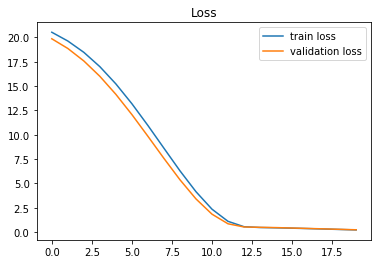

In [20]:
history = model.fit(x=[encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                       encoded_fch, encoded_category_l, encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating],
                    y=local_df['rating'], batch_size=2048, epochs=20, validation_split=0.005, verbose=1)

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss")
plt.show()

In [21]:
# # 모델 저장하기 
# model.save_weights(os.path.join("..","realtime_model",'wnd_local_model2.h5'))

# model_json = model.to_json()
# with open(os.path.join("..","realtime_model","wnd_local_model2.json"), "w") as json_file : 
#     json_file.write(model_json)
    
# print("Saved model to disk")

# item 유사도 반환

In [22]:
# # 모델 불러오기 
# from keras.models import model_from_json 
# json_file = open(os.path.join("..","realtime_model","wnd_local_model2.json"), "r") 
# loaded_model_json = json_file.read() 
# json_file.close() 

# loaded_model = model_from_json(loaded_model_json, custom_objects={'tf': tf, 'n_factors':8})

# loaded_model.load_weights(os.path.join("..","realtime_model","wnd_local_model2.h5"))
# print("Loaded model from disk")

In [23]:
def latent_to_vec(feature, model, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']
    
    # 아이템별 의미 벡터 생성 
    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [25]:
vec = latent_to_vec('FM_locationId', model, local_df, 8, [encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                       encoded_fch, encoded_category_l, encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating])

In [26]:
vec.to_csv(os.path.join("..","realtime_model",'wnd_local_vec2.csv'))#, index=False)

vecs = pd.read_csv(os.path.join("..","realtime_model",'wnd_local_vec2.csv'))
vecs

,locationId,0,1,2,3,4,5,6,7
0,1287253850,-0.044014,-0.044014,-0.043483,-0.043823,-0.043823,-0.043823,-0.043685,-0.042175
1,1135614482,-0.010873,-0.010873,-0.010873,-0.007731,-0.007731,-0.007731,-0.007731,-0.007731
2,18552459,0.021166,0.021166,0.021166,-0.034834,-0.034834,-0.034834,-0.034834,-0.034834
3,1500428988,-0.026898,-0.026898,-0.028970,-0.026881,-0.026881,-0.030319,-0.030319,-0.028179
4,12309433,-0.011607,-0.013392,-0.012658,-0.008739,-0.000185,-0.000720,-0.005492,-0.010083
...,...,...,...,...,...,...,...,...,...
3841,8932954,-0.038551,-0.038551,-0.038551,-0.040554,-0.041127,-0.038085,-0.036253,-0.036596
3842,4171321,-0.074720,-0.074720,-0.074720,-0.075370,-0.075370,-0.075370,-0.075370,-0.075370
3843,4826338,-0.022829,-0.022829,-0.024092,-0.023208,-0.023777,-0.024341,-0.024172,-0.021490
3844,4033778,-0.061940,-0.061182,-0.061182,-0.061182,-0.061182,-0.063386,-0.063386,-0.064602


In [27]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
import random

def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 


def sim_item(vec, df, item_id, top):
    top_id = cosim_id(df, vec, item_id)
    
    if type(top_id) == list :
        df = df.drop_duplicates(['locationId'], keep='last')
        recommend_rst = []
        for x in top_id:
            if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])

        print('input hotel:', local_df.loc[local_df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10)
        for i in range(len(recommend_rst[:top])):
            print('top', i+1, recommend_rst[i][0]['place.name'].values[0])
            print('  주소', recommend_rst[i][0]['land.addr'].values[0])
        
    else:
        answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
        x = random.randint(0, len(answer_lst)-1)
        return answer_lst[x]
    

#### 제거 전

In [710]:
sim_item(vec, local_df, 3477158, 10)

input hotel: Conrad Seoul
----------
top 1 긴자료코 숙대점
  주소 서울특별시 용산구 청파동3가 107-1
top 2 명랑핫도그 잠실장미점
  주소 서울특별시 송파구 신천동 7 장미아파트 에이상가
top 3 101번지남산돈까스
  주소 서울특별시 강남구 역삼동 689-16
top 4 서연황소곱창
  주소 서울특별시 서대문구 창천동 52-119
top 5 현대칼국수
  주소 서울특별시 중구 태평로2가 69-3 청남빌딩
top 6 귀일교자 방배점
  주소 서울특별시 서초구 방배동 911-22
top 7 돈까스참잘하는집
  주소 서울특별시 동작구 신대방동 395-66 보라매삼성쉐르빌
top 8 돈까스의집
  주소 서울특별시 송파구 삼전동 1-4 아카데미빌딩
top 9 카페밸런스
  주소 서울특별시 송파구 잠실동 22-6 리센츠
top 10 스패뉴
  주소 서울특별시 중구 태평로2가 362-1


In [711]:
sim_item(vec, local_df, 0, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.'

In [712]:
sim_item(vec, local_df, 299533, 10)

input hotel: ibis styles Ambassador Seoul Gangnam
----------
top 1 카페게이트 구산사거리점
  주소 서울특별시 은평구 갈현동 498-4 구산빌딩
top 2 하나텐
  주소 서울특별시 강남구 신사동 522 신사아이빌
top 3 뮬리
  주소 서울특별시 강남구 역삼동 641-14
top 4 이디야 촬영소사거리점
  주소 서울특별시 동대문구 장안동 387-4
top 5 따끈따끈하니 쫄깃쫄깃하니
  주소 서울특별시 성북구 동소문동5가 107
top 6 삼두커피
  주소 서울특별시 송파구 문정동 644-2 문정현대지식산업센터1-2
top 7 빠꼬로꼬
  주소 서울특별시 용산구 이태원동 713
top 8 춘리마라탕
  주소 서울특별시 송파구 신천동 11-4 잠실 푸르지오 월드마크
top 9 무이사이공
  주소 서울특별시 서초구 방배동 852-15
top 10 노브랜드버거 경희대점
  주소 서울특별시 동대문구 회기동 60-26


In [713]:
sim_item(vec, local_df, 299152, 10)

input hotel: Best Western Premier Seoul Garden Hotel
----------
top 1 미추원주추어탕서울본점
  주소 서울특별시 관악구 봉천동 1595-8
top 2 빠리가옥
  주소 서울특별시 종로구 익선동 166-26
top 3 다담
  주소 서울특별시 강남구 청담동 97-1 M빌딩
top 4 깐부치킨 신사역점
  주소 서울특별시 강남구 신사동 514-5
top 5 스위트스페이스 현대시티아루렛동대문점
  주소 서울특별시 중구 을지로6가 17-2 현대시티타워
top 6 크앙분식 - 혜화본점
  주소 서울특별시 종로구 연건동 195-38
top 7 호치킨 창동역점
  주소 서울특별시 도봉구 창동 75-13
top 8 Guksuga
  주소 서울특별시 중구 충무로5가 86-3
top 9 인생닭강정
  주소 서울특별시 성북구 동선동1가 85-97
top 10 소피스티케이크
  주소 서울특별시 마포구 서교동 396-54


In [714]:
sim_item(vec, local_df, 6998634, 10)

input hotel: ibis budget Ambassador Seoul Dongdaemun
----------
top 1 바나프레소 길동역점
  주소 서울특별시 강동구 길동 366-5
top 2 진대포
  주소 서울특별시 용산구 갈월동 98-1
top 3 충무로쭈꾸미불고기
  주소 서울특별시 중구 필동1가 3-20
top 4 마녀김밥 노들점
  주소 서울특별시 용산구 이촌동 302-146
top 5 홀리차우
  주소 서울특별시 중구 명동1가 8-1
top 6 스타벅스 쌍문역점
  주소 서울특별시 도봉구 창동 659-5
top 7 김밥천국
  주소 서울특별시 마포구 망원동 395-4
top 8 내고향횡성한우정육점식당
  주소 서울특별시 송파구 방이동 66-3 석촌씨티빌딩
top 9 가야랑
  주소 서울특별시 용산구 이태원2동 239-4
top 10 돈수작 건대점
  주소 서울특별시 광진구 화양동 9-19


In [715]:
sim_item(vec, local_df, 1796658, 10)

input hotel: Banyan Tree Club & Spa Seoul
----------
top 1 조아저씨김치찌개와막겹구이
  주소 서울특별시 중구 서소문동 23
top 2 탐앤탐스
  주소 서울특별시 서초구 반포동 20-45 반포자이플라자
top 3 황소고집
  주소 서울특별시 종로구 관철동 11-11
top 4 서울감자탕
  주소 서울특별시 강동구 성내동 199-11
top 5 써브웨이 상암DMC푸르지오시티점
  주소 서울특별시 마포구 상암동 1596 상암DMC푸르지오시티, S-City
top 6 밥이답이다 신촌세브란스병원점
  주소 서울특별시 서대문구 신촌동 134 신촌세브란스병원
top 7 모힝
  주소 서울특별시 관악구 봉천동 1598-6
top 8 푸주옥
  주소 서울특별시 양천구 신정동 1290-2
top 9 마포 갈매기
  주소 서울특별시 마포구 도화동 194-8
top 10 돈암동찌개
  주소 서울특별시 강북구 수유동 191-66


In [716]:
sim_item(vec, local_df, 306118, 10)

input hotel: Grand InterContinental Seoul Parnas
----------
top 1 곳온니플레이스
  주소 서울특별시 영등포구 여의도동 17 여의도더샵아일랜드파크
top 2 풀향기
  주소 서울특별시 용산구 한남동 726-54 풀향기(음식점)
top 3 센터커피
  주소 서울 성동구 서울숲2길 28-11 2층
top 4 그랜드뮤즈
  주소 서울특별시 용산구 한남동 726-419
top 5 달구벌반점
  주소 서울특별시 성동구 성수동2가 278-25
top 6 정성본 샤브수끼 칼국수 강남역점
  주소 서울특별시 서초구 서초동 1321-9 풍림아이원매직
top 7 브릭하우스76
  주소 서울특별시 은평구 역촌동 35-29
top 8 장군갈비
  주소 서울특별시 영등포구 문래동3가 55-5 로데오 왘 쇼핑몰
top 9 담소소사골순대육개장 가산디지털점
  주소 서울특별시 금천구 가산동 60-11 스타밸리
top 10 평양냉면
  주소 서울특별시 구로구 오류동 13-55


아무리 생각해도 '명량핫도그','이디야','김밥천국','탐앤탐스','서브웨이' 추천은 모르겠다.....  
휴리스틱하게 직접 결과창 보고 아니다 싶은 추천 장소는 제거했음.  
### local이기에 global과 차이를 두기위해 최대한 의미없는 체인 제거

In [20]:
sim_item(vec, local_df, 10205834, 10)

input hotel: Tmark Grand Hotel Myeongdong
----------
top 1 원남가배
  주소 서울특별시 종로구 원남동 89-3
top 2 무차초 서울
  주소 서울특별시 강남구 역삼동 812-18
top 3 규자카야 모토
  주소 서울특별시 마포구 연남동 224-26
top 4 피에르 가니에르 서울
  주소 서울특별시 중구 소공동 1 롯데백화점 본점
top 5 서래마을이야기
  주소 서울특별시 서초구 반포동 549-11
top 6 된장예술과술
  주소 서울특별시 종로구 관철동 12-7
top 7 마루
  주소 서울특별시 용산구 용산동6가 168-6 국립중앙박물관
top 8 카페르뷰
  주소 서울특별시 중구 쌍림동 151-9 오랜후레쉬빌딩
top 9 블랙빈스
  주소 서울특별시 성동구 응봉동 228-20
top 10 해피니스 디저트
  주소 서울특별시 광진구 자양동 848-2


In [21]:
sim_item(vec, local_df, 0, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.'

In [22]:
sim_item(vec, local_df, 11555954, 10)

input hotel: 그랜드 하얏트 서울
----------
top 1 채근담
  주소 서울특별시 강남구 대치동 983 태범빌딩
top 2 신룽푸마라탕
  주소 서울특별시 중구 을지로2가 199-58
top 3 마천아구
  주소 서울특별시 강동구 명일동 344-15 에이플러스
top 4 농민백암순대
  주소 서울특별시 강남구 역삼동 830-9
top 5 치킨매니아
  주소 서울특별시 중구 북창동 19-1
top 6 로얄수제돈까스
  주소 서울특별시 중구 쌍림동 25-15
top 7 시즌
  주소 서울특별시 노원구 상계동 358-6
top 8 셰프스 노트
  주소 서울특별시 강남구 삼성동 159 호텔오크우드프리미어
top 9 나인어클락
  주소 서울특별시 강남구 논현동 84 송암빌딩
top 10 베이스
  주소 서울특별시 강남구 역삼동 826-3


In [23]:
sim_item(vec, local_df, 1011796922, 10)

input hotel: 호텔더디자이너스동대문
----------
top 1 하궁
  주소 서울특별시 종로구 삼청동 73
top 2 광화문이층집
  주소 서울특별시 종로구 견지동 110 종로1가 대성 스카이렉스
top 3 녹기 전에
  주소 서울특별시 종로구 익선동 120
top 4 김가네칼국수
  주소 서울특별시 마포구 연남동 225-35 MH빌딩
top 5 나미루라멘
  주소 서울특별시 강남구 수서동 713 수서현대벤쳐빌
top 6 레오니다스초콜릿카페
  주소 서울특별시 중구 명동2가 2-1 재원빌딩
top 7 마포족발순대국
  주소 서울특별시 구로구 신도림동 337 신도림1차푸르지오
top 8 카사블랑카 샌드위치
  주소 서울특별시 용산구 용산동2가 44-8
top 9 롭다
  주소 서울특별시 마포구 연남동 260-16
top 10 최대감네
  주소 서울특별시 종로구 경운동 64-47


In [24]:
sim_item(vec, local_df, 37903636, 10)

input hotel: 아만티호텔서울
----------
top 1 지리산어탕국수
  주소 서울특별시 마포구 합정동 386-38
top 2 로우커피스탠드
  주소 서울특별시 성동구 성수동1가 8-16
top 3 더멜팅팟
  주소 서울특별시 관악구 봉천동 1613-4
top 4 발리문
  주소 서울특별시 마포구 연남동 228-48
top 5 오늘은 보글부대
  주소 서울특별시 은평구 응암동 580-19 로즈빌
top 6 카우떡볶이
  주소 서울특별시 서대문구 대현동 34-40
top 7 이가탕수6
  주소 서울특별시 마포구 동교동 147-21
top 8 화곡영양족발
  주소 서울특별시 강서구 화곡동 98-154
top 9 펠리치타
  주소 서울특별시 관악구 신림동 119-9
top 10 치즈룸
  주소 서울특별시 강남구 신사동 603


In [25]:
sim_item(vec, local_df, 32092219, 10)

input hotel: 스타일리시M호텔
----------
top 1 무교동북어국집
  주소 서울특별시 중구 다동 173
top 2 미스터김밥
  주소 서울특별시 마포구 도화동 555
top 3 인도로가는길 레스토랑
  주소 서울특별시 종로구 관훈동 198-36 오원빌딩
top 4 지하철다방
  주소 서울특별시 종로구 종로5가 182-4 흥일빌딩
top 5 성수다락
  주소 서울특별시 성동구 성수동2가 328-15
top 6 용정바른얼굴식당
  주소 서울특별시 마포구 연남동 390-41
top 7 동흥관
  주소 서울특별시 금천구 시흥동 115-10 동흥관
top 8 PLANT
  주소 서울특별시 용산구 이태원동 130-43
top 9 성신여대 팬쿡
  주소 서울특별시 성북구 동선동1가 85-40
top 10 서동한우
  주소 서울특별시 서초구 서초동 1327-29 서초파라곤


In [26]:
sim_item(vec, local_df, 306118, 10)

input hotel: Grand InterContinental Seoul Parnas
----------
top 1 굿모닝
  주소 서울특별시 종로구 인의동 112-2 세운스퀘어
top 2 옛날국수맛집
  주소 서울특별시 종로구 체부동 47-1
top 3 더블루버드
  주소 서울특별시 동대문구 회기동 346-16
top 4 하동관
  주소 서울특별시 강남구 대치동 891-44 노벨빌딩
top 5 파오파오
  주소 서울특별시 송파구 잠실동 35-2 트리지움
top 6 불이아
  주소 서울특별시 종로구 동숭동 25-10
top 7 카페무라노
  주소 서울특별시 강남구 역삼동 601-30
top 8 add coffee
  주소 서울특별시 중구 주교동 112
top 9 17도씨
  주소 서울특별시 마포구 연남동 257-21 함아현
top 10 뚜레곱창
  주소 서울특별시 성북구 동소문동5가 107


데이터 업뎃 후

In [55]:
import random

for location_id in common_acm_ids[:10]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔에잇아워즈
----------
top 1 일상별식
  주소 서울특별시 구로구 신도림동 692 디큐브시티
top 2 할머니추어탕
  주소 서울특별시 구로구 개봉동 403-22 개봉동청송빌딩
top 3 묘오또
  주소 서울특별시 서초구 방배동 850-1 세광빌딩
top 4 도단집
  주소 서울특별시 광진구 화양동 47-41
top 5 르빵
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 6 오투베이커리
  주소 서울특별시 마포구 대흥동 322-2
top 7 스시긴
  주소 서울특별시 동대문구 장안동 372-3 SM타워 오피스텔
top 8 카페 228-9
  주소 서울특별시 마포구 연남동 228-9
top 9 보칼리노
  주소 error
top 10 김태완스시
  주소 서울특별시 강남구 대치동 923-16 디앤비빌딩
None



--------------------------------------------------
input hotel: 노보텔스위트앰배서더서울용산
----------
top 1 소바식당
  주소 서울특별시 마포구 망원동 378-9
top 2 브레드숨
  주소 서울특별시 동작구 본동 187-4
top 3 희래식당
  주소 서울특별시 서대문구 창천동 13-28
top 4 슬로우브레드파파
  주소 서울특별시 성북구 동선동2가 142-2
top 5 황태뚝배기해장국
  주소 서울특별시 마포구 도화동 536 정우빌딩
top 6 다글다글
  주소 서울특별시 관악구 남현동 1083-8 소망이있는집
top 7 휴
  주소 서울특별시 종로구 익선동 22-2
top 8 완도전복
  주소 서울특별시 중구 신당동 373-129
top 9 서지
  주소 서울특별시 용산구 남영동 33-4
top 10 나노기분식
  주소 서울특별시 은평구 녹번동 21-134
None



--------------------------------------------------
input hotel: 오리엔스호텔&레지던스
---------

In [56]:
import random

for location_id in common_acm_ids[10:20]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 롯데시티호텔 마포
----------
top 1 목멱산방
  주소 서울특별시 중구 남산동2가 25-4
top 2 국수찾아 닭만리
  주소 서울특별시 종로구 낙원동 110 경한빌딩
top 3 장원각
  주소 서울특별시 중구 장충동2가 200-1
top 4 오바도즈
  주소 서울특별시 마포구 서교동 401-13
top 5 이지웨이
  주소 서울특별시 강서구 방화동 886 김포공항, 롯데몰, 스카이시티
top 6 라콘티넨탈
  주소 서울특별시 중구 장충동2가 202 신라호텔
top 7 공평동꼼장어
  주소 서울특별시 종로구 관철동 42-4
top 8 딥블루레이크 커피&로스터스
  주소 서울특별시 마포구 망원1동 411-12
top 9 동차밥
  주소 서울특별시 마포구 연남동 390-78
top 10 통인동커피공방
  주소 서울특별시 종로구 통인동 118-3
None



--------------------------------------------------
input hotel: 레스케이프 호텔
----------
top 1 장충동한방족발
  주소 서울특별시 광진구 자양동 623-46
top 2 홍콩반점0410
  주소 서울특별시 종로구 명륜2가 184
top 3 아이오유
  주소 서울특별시 용산구 청암동 164
top 4 전라도시네마
  주소 서울특별시 관악구 서원동 1640-31 민속순대타운
top 5 할머니포장마차멸치국수
  주소 서울특별시 송파구 방이동 49-5 올림픽파크존
top 6 재인
  주소 서울특별시 서대문구 연희동 85-17
top 7 땅코참숯구이
  주소 서울특별시 성동구 행당동 298-55
top 8 레어 마카롱
  주소 서울특별시 송파구 송파동 58-4 레이크 해모로
top 9 달인겉절이칼국수보쌈
  주소 서울특별시 중구 저동1가 104 파인에비뉴
top 10 청수당
  주소 서울특별시 종로구 익선동 144
None



--------------------------------------------------
in

In [57]:
import random

for location_id in common_acm_ids[20:30]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 강남아르누보시티
----------
top 1 슬기분식
  주소 서울특별시 중구 신당동 348-37
top 2 양키스버거
  주소 서울특별시 종로구 익선동 133-2
top 3 마포곱창타운
  주소 서울특별시 마포구 동교동 197-5
top 4 4 Lines Coffee
  주소 서울특별시 관악구 신림동 1639-6
top 5 는커피
  주소 서울특별시 중구 신당동 288-17
top 6 우아한형제들
  주소 서울특별시 마포구 아현동 686 크레디트센터빌딩
top 7 개미집1
  주소 서울특별시 광진구 화양동 508-2
top 8 고봉삼계탕
  주소 서울특별시 강남구 삼성동 159 코엑스인터콘티넨탈서울
top 9 함스브로트
  주소 서울특별시 도봉구 쌍문동 88-106
top 10 빵의정석
  주소 서울특별시 성동구 성수동1가 668-49
None



--------------------------------------------------
input hotel: TheK호텔 서울
----------
top 1 맛이차이나
  주소 서울특별시 마포구 상수동 321-1
top 2 소풍가는날
  주소 서울특별시 관악구 봉천동 1657-21
top 3 1984
  주소 서울특별시 마포구 동교동 158-24 혜원빌딩
top 4 요란한부엌
  주소 서울특별시 동작구 사당동 1032-8
top 5 크렘드마롱
  주소 서울특별시 강남구 청담동 77-76 청담역
top 6 육회자매집
  주소 서울특별시 종로구 종로4가 177 제우빌딩
top 7 한입소반
  주소 서울특별시 용산구 청파동3가 15-5
top 8 맛짱
  주소 서울특별시 송파구 신천동 17-4 파크리오
top 9 커피노운
  주소 서울특별시 강남구 역삼동 819-4
top 10 창신매운왕족발
  주소 서울특별시 종로구 창신동 142-29
None



--------------------------------------------------
input hotel: 롯데시티호텔 구로
---

In [58]:
import random

for location_id in common_acm_ids[30:40]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 글래드 여의도
----------
top 1 다옴
  주소 서울특별시 강서구 마곡동 796-7
top 2 홍대씨부엉
  주소 서울특별시 마포구 서교동 358-39
top 3 혜화문아래
  주소 서울특별시 성북구 성북동1가 35-4
top 4 세드라
  주소 서울특별시 강남구 대치동 900-16 샬롬빌
top 5 바우닭강정
  주소 서울특별시 광진구 자양동 612-36
top 6 챔프커피 제2작업실
  주소 서울특별시 용산구 이태원동 79-44
top 7 홍대 닭갈비(N)
  주소 서울특별시 마포구 서교동 357-2
top 8 히메시야
  주소 서울특별시 마포구 상수동 313-1
top 9 속초그바람에
  주소 서울특별시 강서구 등촌동 674-2
top 10 미분당
  주소 서울특별시 관악구 봉천동 300-8
None



--------------------------------------------------
input hotel: 더스테이트 선유 호텔
----------
top 1 오모가리김치찌개
  주소 서울특별시 강남구 역삼동 738-1 역삼동JESS
top 2 이한스시
  주소 서울특별시 영등포구 당산동1가 256-58 대일빌딩
top 3 홍제파스타
  주소 서울특별시 서대문구 홍제동 330-92
top 4 카페마마스
  주소 서울특별시 강남구 압구정동 494 갤러리아백화점
top 5 ESTD 2017
  주소 서울특별시 종로구 효제동 61-1
top 6 고기온
  주소 서울특별시 중구 쌍림동 155-5
top 7 마포즉석모밀촌
  주소 서울특별시 마포구 합정동 449-5
top 8 롯데호텔월드 라세느
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 9 제로베이스커피
  주소 서울특별시 마포구 서교동 408-17
top 10 다이칸야마키친
  주소 서울특별시 강남구 신사동 524-19
None



--------------------------------------------------
input hotel: 신라스

In [59]:
import random

for location_id in common_acm_ids[40:50]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 나인트리프리미어호텔 명동2
----------
top 1 노란상 소갈비
  주소 서울특별시 강남구 논현동 112-7
top 2 한냄비
  주소 서울특별시 용산구 한남동 631-17
top 3 미분당
  주소 서울특별시 관악구 봉천동 300-8
top 4 동남집 대륭 17차
  주소 서울특별시 금천구 가산동 670 대륭테크노타운17차
top 5 속초그바람에
  주소 서울특별시 강서구 등촌동 674-2
top 6 헤일리스커피
  주소 서울특별시 서초구 양재동 275-4 트윈타워
top 7 단풍나무집
  주소 서울특별시 종로구 삼청동 31-1
top 8 후레쉬빌
  주소 서울특별시 강남구 대치동 999
top 9 돈수백
  주소 서울특별시 마포구 동교동 164-24
top 10 병철이네치맛살
  주소 서울특별시 마포구 상수동 146-18
None



--------------------------------------------------
input hotel: 노보텔 앰배서더 서울 강남
----------
top 1 깐부치킨
  주소 서울특별시 서초구 잠원동 67-6
top 2 포메인
  주소 서울특별시 서초구 서초동 1366-5
top 3 대원식당
  주소 서울특별시 용산구 용산동3가 1-64
top 4 BLT 스테이크
  주소 서울특별시 종로구 종로6가 289-3
top 5 대성집
  주소 서울특별시 동대문구 용두동 754-9
top 6 화통본가
  주소 서울특별시 종로구 종로3가 123-3
top 7 돈카츠윤석
  주소 서울특별시 마포구 신수동 36-3
top 8 호아빈
  주소 서울특별시 중구 을지로2가 199-58
top 9 트라토리아 챠오
  주소 서울특별시 마포구 상수동 327-1
top 10 커피별녹색잔
  주소 서울특별시 양천구 신정동 988-14
None



--------------------------------------------------
input hotel: 코트야드 메리어트 서울 보타닉파크 호텔
-----

In [60]:
import random

for location_id in common_acm_ids[50:60]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 베스트웨스턴프리미어서울가든호텔
----------
top 1 모터시티
  주소 서울특별시 송파구 송파동 42-6
top 2 영천 떡볶이
  주소 서울특별시 서대문구 영천동 69-64
top 3 신당동천팥죽
  주소 서울특별시 중구 신당동 120-26
top 4 달식당
  주소 서울특별시 종로구 관훈동 198-8 종로빌딩
top 5 라노떼
  주소 서울특별시 강남구 신사동 652-7 젤로빌딩
top 6 헬로그린
  주소 서울특별시 강남구 역삼동 825-20 강남역 센트럴 푸르지오 시티
top 7 황소랑
  주소 서울특별시 강서구 마곡동 795-2 마곡아이파크
top 8 페어링룸
  주소 서울특별시 강남구 청담동 117-12
top 9 젠틀서퍼
  주소 서울특별시 마포구 서교동 403-22 실버스톤II
top 10 카레오
  주소 서울특별시 영등포구 여의도동 47 여의도자이
None



--------------------------------------------------
input hotel: 머큐어 서울 앰배서더 강남 쏘도베
----------
top 1 치킨앤곱창
  주소 서울특별시 관악구 봉천동 1638-1
top 2 카페매화
  주소 서울특별시 마포구 연남동 260-4 클라인하우제 홍대
top 3 유일설렁탕
  주소 서울특별시 광진구 중곡동 18-13 유일설렁탕
top 4 이천가든
  주소 서울특별시 강남구 삼성동 159 코엑스인터콘티넨탈서울
top 5 공평동꼼장어
  주소 서울특별시 종로구 관철동 42-4
top 6 통인동커피공방
  주소 서울특별시 종로구 통인동 118-3
top 7 동차밥
  주소 서울특별시 마포구 연남동 390-78
top 8 기절초풍왕순대
  주소 서울특별시 관악구 봉천동 1620-38
top 9 온돈부리
  주소 서울특별시 마포구 상암동 1596 상암DMC푸르지오시티, S-City
top 10 선진국낙지마당
  주소 서울특별시 동대문구 장안동 306-11
None



-----------------

In [61]:
import random

for location_id in common_acm_ids[60:70]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 오라카이 인사동 스위츠
----------
top 1 춘리마라탕
  주소 서울특별시 송파구 신천동 11-4 잠실 푸르지오 월드마크
top 2 루위
  주소 서울특별시 강남구 신사동 587-14 동현빌딩
top 3 설레임삼겹살
  주소 서울특별시 서대문구 창천동 57-40 낙원빌딩
top 4 이즈니베이커리
  주소 서울특별시 강남구 삼성동 159-7 현대백화점
top 5 연건삼계탕
  주소 서울특별시 종로구 연건동 86
top 6 가야성
  주소 서울특별시 동작구 상도동 492-17
top 7 상수돼집
  주소 서울특별시 마포구 상수동 317-10
top 8 카페413프로젝트
  주소 서울특별시 강남구 역삼동 640-9
top 9 카페엣모스피어‬
  주소 서울특별시 마포구 망원동 416-2
top 10 댓짱돈까스
  주소 서울특별시 양천구 목동 923-6 예술인회관
None



--------------------------------------------------
input hotel: 롯데시티호텔 명동
----------
top 1 작은스페인
  주소 서울특별시 서대문구 연희동 81-27
top 2 라운지
  주소 서울특별시 서초구 양재동 246-6 인사이트
top 3 펀비어킹
  주소 서울특별시 서초구 방배동 909-11 나이스빌
top 4 낙지일번지
  주소 서울특별시 강북구 수유동 191-38
top 5 홍두깨손칼국수
  주소 서울특별시 마포구 망원동 414-26
top 6 백제추어탕
  주소 서울특별시 강동구 둔촌동 486-5
top 7 카페 원오프
  주소 서울특별시 성북구 동선동2가 128
top 8 미소다이닝
  주소 서울특별시 강남구 역삼동 820-1 로하스애비뉴빌딩
top 9 유부
  주소 서울특별시 마포구 망원동 414-82
top 10 화떡
  주소 서울특별시 중구 명동2가 54-26
None



--------------------------------------------------
input hotel: 

In [62]:
import random

for location_id in common_acm_ids[70:80]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 그라모스호텔
----------
top 1 커피기업
  주소 서울특별시 종로구 수송동 156 G타워
top 2 또와순두부수제비
  주소 서울특별시 노원구 상계동 323-32 산호빌딩
top 3 막불감동
  주소 서울특별시 관악구 신림동 1433-60
top 4 민물장어직판장 장어세상
  주소 서울특별시 서대문구 홍은동 48-185
top 5 쟈니덤플링
  주소 서울특별시 용산구 이태원동 130-3
top 6 초림정
  주소 서울특별시 성북구 돈암동 48-4 성북성심빌딩
top 7 이주당
  주소 서울특별시 종로구 체부동 189
top 8 독수리다방
  주소 서울특별시 서대문구 창천동 31-4 독수리빌딩
top 9 3일한우국밥
  주소 서울특별시 영등포구 영등포동4가 68-5
top 10 원조보리밥
  주소 서울특별시 용산구 이태원동 34-103
None



--------------------------------------------------
input hotel: MEASeoul
----------
top 1 카와카츠
  주소 서울특별시 마포구 서교동 465-1 광남벨라스아파트
top 2 진성한우곱창
  주소 서울특별시 강동구 천호동 415-5
top 3 부엌쟁이
  주소 서울특별시 동작구 사당동 1006-4
top 4 코트야드메리어트서울타임스퀘어 모모바
  주소 서울특별시 영등포구 영등포동4가 442 타임스퀘어
top 5 진순두부
  주소 서울특별시 구로구 구로동 170-10 대륭포스트타워7차
top 6 홍등
  주소 서울특별시 서초구 서초동 1564-2
top 7 박고볼래
  주소 서울특별시 강남구 논현동 242-16
top 8 포490 베트남 쌀국수
  주소 서울특별시 강남구 역삼동 858 강남역
top 9 웰빙김치찜
  주소 서울특별시 마포구 공덕동 256-5
top 10 가로수길 칼국수
  주소 서울특별시 강남구 신사동 510-11 강남상가아파트
None



----------------------------------

In [63]:
import random

for location_id in common_acm_ids[80:90]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 토요코인 서울강남
----------
top 1 산하
  주소 서울특별시 영등포구 여의도동 44-14 경도빌딩
top 2 펠리치타
  주소 서울특별시 관악구 신림동 119-9
top 3 성북동 누룽지백숙
  주소 서울특별시 성북구 성북동 281-1
top 4 빵나무
  주소 서울특별시 마포구 동교동 201-48
top 5 최종병기맛
  주소 서울특별시 영등포구 여의도동 15-24 익스콘벤처타워
top 6 로아베이커리
  주소 서울특별시 마포구 서교동 468-2
top 7 구스토 타코
  주소 서울특별시 마포구 상수동 146-6
top 8 LA북창동순두부
  주소 서울특별시 구로구 구로동 184-1 우림이비지센터2차
top 9 아프리카커피
  주소 서울특별시 중랑구 신내동 387-1 삼부그린스포츠센터
top 10 루이스버거
  주소 서울특별시 노원구 공릉동 441-92
None



--------------------------------------------------
input hotel: 호텔 아이린
----------
top 1 카페 & 타파스 도깨비코티지
  주소 서울특별시 용산구 후암동 435
top 2 빠꼬로꼬
  주소 서울특별시 용산구 이태원동 713
top 3 떡볶이파티
  주소 서울특별시 중구 필동2가 32-11 삼지빌딩
top 4 쭈꾸미 한상
  주소 서울특별시 강남구 논현동 144
top 5 오븐에빠진닭
  주소 서울특별시 강남구 역삼동 831-26
top 6 문정한방삼계탕
  주소 서울특별시 송파구 문정동 643-1 엠스테이트
top 7 스시토라
  주소 서울특별시 양천구 목동 405-241
top 8 전봇대곱창
  주소 서울특별시 영등포구 신길동 99-7
top 9 우동명가기리야마본진
  주소 서울특별시 강남구 역삼동 824-11 한라클래식오피스텔
top 10 다이칸야마키친
  주소 서울특별시 강남구 신사동 524-19
None



--------------------------------------------

In [64]:
import random

for location_id in common_acm_ids[90:100]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 시그니엘 서울
----------
top 1 반쥴
  주소 서울특별시 종로구 관철동 12-16
top 2 콩부자
  주소 서울특별시 강서구 화곡동 1026-6
top 3 블루룸
  주소 서울특별시 종로구 명륜4가 66-3
top 4 ffanci
  주소 서울특별시 광진구 중곡동 236-7
top 5 셀러브리티 버거스테이지
  주소 서울특별시 강남구 대치동 923-13 서진빌딩
top 6 청화초밥
  주소 서울특별시 송파구 방이동 69-9
top 7 잭스바
  주소 서울특별시 용산구 이태원동 116-14
top 8 Bros스테이크보쌈
  주소 서울특별시 동작구 노량진동 126-11 서림독서실
top 9 공평동꼼장어
  주소 서울특별시 종로구 관철동 42-4
top 10 포브라더스
  주소 서울특별시 강남구 도곡동 423-5 덕영빌딩
None



--------------------------------------------------
input hotel: 그랜드 인터컨티넨탈 서울 파르나스
----------
top 1 와플잇업
  주소 서울특별시 서대문구 대현동 27-17
top 2 혜화칼국수
  주소 서울특별시 종로구 혜화동 84-3
top 3 스시우찌
  주소 서울특별시 강남구 신사동 660-17 압구정로데오스타
top 4 본솔커피
  주소 서울특별시 용산구 청파동2가 64-13
top 5 팔백집
  주소 서울특별시 성북구 동선동2가 172
top 6 몽소
  주소 서울특별시 동작구 대방동 394-7 대방동빌딩
top 7 예가
  주소 서울특별시 노원구 중계동 43-10
top 8 코이크
  주소 서울특별시 마포구 연남동 255-23
top 9 미분당
  주소 서울특별시 종로구 명륜4가 188-4 동화빌딩
top 10 돈돼랑
  주소 서울특별시 강서구 화곡동 1072-1
None



--------------------------------------------------
input hotel: 노보텔 앰배서더 서울 용산
----

In [65]:
import random

for location_id in common_acm_ids[100:110]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 나포레
----------
top 1 커피볶는이야기두번째공간
  주소 서울특별시 성북구 동소문동1가 32-2
top 2 스미비부타동
  주소 서울특별시 마포구 상수동 92-6
top 3 더 라운지, 파크 하얏트 서울
  주소 error
top 4 아리랑 수미감자탕
  주소 서울특별시 성북구 동선동5가 154
top 5 황평집
  주소 서울특별시 중구 인현동2가 135-13
top 6 마부자생삼겹살
  주소 서울특별시 강서구 마곡동 760 마곡나루역보타닉푸르지오시티
top 7 원주골돌솥추어탕
  주소 서울특별시 관악구 신림동 1445-14
top 8 닌자스시
  주소 서울특별시 송파구 잠실동 188-12
top 9 시타시이베이커리
  주소 서울특별시 강서구 내발산동 714-4 태승훼미리아파트5차
top 10 보훈병원상조회
  주소 서울특별시 강동구 둔촌동 6-2 중앙보훈병원
None



--------------------------------------------------
input hotel: 세종 호텔
----------
top 1 온돈부리
  주소 서울특별시 마포구 상암동 1596 상암DMC푸르지오시티, S-City
top 2 광장쑥자매 찹쌀호떡
  주소 서울특별시 종로구 예지동 2-1
top 3 우작설렁탕
  주소 서울특별시 서초구 서초동 1621-5 홍빌딩
top 4 마싯내
  주소 서울특별시 송파구 석촌동 157-4 수정빌딩
top 5 소이연남
  주소 서울특별시 마포구 연남동 229-67
top 6 그림나베
  주소 서울특별시 서초구 서초동 1603-1 블루핀타워
top 7 서태자김밥세상
  주소 서울특별시 관악구 봉천동 1671-6
top 8 오차드1974
  주소 서울특별시 중구 신당동 250-14
top 9 동우황태북어
  주소 서울특별시 송파구 문정동 221
top 10 가미우동
  주소 서울특별시 마포구 서교동 346-31
None



---------------------------------------

In [66]:
import random

for location_id in common_acm_ids[110:120]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 플로라 호텔신신 서울 명동
----------
top 1 원남가배
  주소 서울특별시 종로구 원남동 89-3
top 2 춘천집 닭갈비막국수
  주소 서울특별시 서대문구 창천동 57-8
top 3 오메가삼계탕
  주소 서울특별시 용산구 이촌동 302-64 장미아파트
top 4 복성각
  주소 서울특별시 마포구 도화동 173 삼창프라자빌딩
top 5 천호낙지
  주소 서울특별시 동대문구 장안동 107-8 삼협메디스빌딩
top 6 펜앤커피
  주소 서울특별시 종로구 관훈동 198-10 종로빌딩
top 7 박가네빈대떡
  주소 서울특별시 종로구 종로5가 138-10
top 8 로네펠트 티하우스 서대문
  주소 서울특별시 서대문구 충정로2가 78
top 9 A4아시안키친
  주소 서울특별시 마포구 공덕동 477 공덕파크자이
top 10 도프커피
  주소 서울특별시 마포구 상암동 1597 사보이시티디엠씨
None



--------------------------------------------------
input hotel: 더 플라자
----------
top 1 치킨앤곱창
  주소 서울특별시 관악구 봉천동 1638-1
top 2 카페매화
  주소 서울특별시 마포구 연남동 260-4 클라인하우제 홍대
top 3 유일설렁탕
  주소 서울특별시 광진구 중곡동 18-13 유일설렁탕
top 4 이천가든
  주소 서울특별시 강남구 삼성동 159 코엑스인터콘티넨탈서울
top 5 공평동꼼장어
  주소 서울특별시 종로구 관철동 42-4
top 6 통인동커피공방
  주소 서울특별시 종로구 통인동 118-3
top 7 동차밥
  주소 서울특별시 마포구 연남동 390-78
top 8 기절초풍왕순대
  주소 서울특별시 관악구 봉천동 1620-38
top 9 온돈부리
  주소 서울특별시 마포구 상암동 1596 상암DMC푸르지오시티, S-City
top 10 선진국낙지마당
  주소 서울특별시 동대문구 장안동 306-11
None



-----------------

In [67]:
import random

for location_id in common_acm_ids[120:130]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 이비스 버젯 앰배서더 서울 동대문
----------
top 1 동적불고기
  주소 서울특별시 도봉구 창동 443-8
top 2 텅앤그루브조인트
  주소 서울특별시 용산구 이태원동 127-15
top 3 올레김밥
  주소 서울특별시 송파구 신천동 17-4 파크리오
top 4 압구정미연
  주소 서울특별시 강남구 신사동 662-19
top 5 함스브로트
  주소 서울특별시 도봉구 쌍문동 88-106
top 6 프랑제리
  주소 서울특별시 서초구 잠원동 70-1 킴스클럽
top 7 서교가든
  주소 서울특별시 마포구 서교동 466-1
top 8 홋카이도부타동스미레
  주소 서울특별시 서대문구 창천동 5-32
top 9 나무와 벽돌
  주소 서울특별시 종로구 신문로1가 6
top 10 육영토종한우
  주소 서울특별시 영등포구 당산동4가 32-111
None



--------------------------------------------------
input hotel: 호텔 코지 명동
----------
top 1 창포
  주소 서울특별시 강남구 대치동 936-18
top 2 북해빙수
  주소 서울특별시 중구 흥인동 158-9
top 3 우스블랑
  주소 서울특별시 용산구 효창동 5-51
top 4 아빠곰수제돈까스
  주소 서울특별시 서초구 서초동 1310-5 영동프라자
top 5 얄개시대
  주소 서울특별시 중구 충무로4가 25
top 6 빽다방 - 신용산역
  주소 서울특별시 용산구 한강로2가 2-196
top 7 라오제대만대왕카스테라
  주소 서울특별시 강서구 방화동 564-85 수진타워
top 8 춘천골 숯불 닭갈비
  주소 서울특별시 관악구 신림동 1433-128
top 9 수돈재
  주소 서울특별시 광진구 중곡동 114-34
top 10 오레노카츠
  주소 서울특별시 성동구 성수동1가 16-8 송도빌딩
None



--------------------------------------------------
input hotel

In [68]:
import random

for location_id in common_acm_ids[130:140]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 케이팝 레지던스 명동 1
----------
top 1 목멱산방
  주소 서울특별시 중구 남산동2가 25-4
top 2 길목
  주소 서울특별시 강남구 삼성동 58-6 진성빌딩
top 3 결
  주소 서울특별시 종로구 공평동 17
top 4 그랜드 인터컨티넨탈 서울 파르나스 그랜드 키친
  주소 서울특별시 강남구 삼성동 159-8 파르나스타워
top 5 이천가든
  주소 서울특별시 강남구 삼성동 159 코엑스인터콘티넨탈서울
top 6 국수찾아 닭만리
  주소 서울특별시 종로구 낙원동 110 경한빌딩
top 7 소이연남
  주소 서울특별시 마포구 연남동 229-67
top 8 셀러브리티 버거스테이지
  주소 서울특별시 강남구 대치동 923-13 서진빌딩
top 9 공평동꼼장어
  주소 서울특별시 종로구 관철동 42-4
top 10 라콘티넨탈
  주소 서울특별시 중구 장충동2가 202 신라호텔
None



--------------------------------------------------
input hotel: 호텔더디자이너스 디디피
----------
top 1 혜화칼국수
  주소 서울특별시 종로구 혜화동 84-3
top 2 본솔커피
  주소 서울특별시 용산구 청파동2가 64-13
top 3 팔백집
  주소 서울특별시 성북구 동선동2가 172
top 4 서울뼈구이매운족발
  주소 서울특별시 동대문구 전농동 602-9
top 5 브레드비
  주소 서울특별시 마포구 상암동 1601 케이지아이티센터
top 6 파네트 크루아상팩토리
  주소 서울특별시 종로구 내수동 71 경희궁의아침 2단지
top 7 소문난순대국왕족발
  주소 서울특별시 마포구 망원동 479-68 동아빌딩
top 8 육덕식당
  주소 서울특별시 강남구 논현동 201-5
top 9 개미집1
  주소 서울특별시 광진구 화양동 508-2
top 10 비나
  주소 서울특별시 동대문구 제기동 137-41
None



---------------------------------

In [69]:
import random

for location_id in common_acm_ids[140:150]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 현대레지던스
----------
top 1 커피기업
  주소 서울특별시 종로구 수송동 156 G타워
top 2 3일한우국밥
  주소 서울특별시 영등포구 영등포동4가 68-5
top 3 또와순두부수제비
  주소 서울특별시 노원구 상계동 323-32 산호빌딩
top 4 막불감동
  주소 서울특별시 관악구 신림동 1433-60
top 5 미정
  주소 서울특별시 서대문구 연희동 192-29
top 6 민물장어직판장 장어세상
  주소 서울특별시 서대문구 홍은동 48-185
top 7 애성회관한우곰탕
  주소 서울특별시 중구 북창동 93-36 세창빌딩
top 8 MouseRabbit
  주소 서울특별시 광진구 화양동 5-14
top 9 스티머스
  주소 서울특별시 영등포구 여의도동 15-16 산정빌딩
top 10 육품
  주소 서울특별시 성동구 성수동2가 339-136
None



--------------------------------------------------
input hotel: 호텔 통 비바체 동대문
----------
top 1 정가네부엌
  주소 서울특별시 강남구 개포동 1240-4
top 2 코야코
  주소 서울특별시 종로구 동숭동 128-5 호은빌딩
top 3 듀윗
  주소 서울특별시 마포구 연남동 260-14
top 4 나인스게이트
  주소 서울특별시 중구 소공동 87-1 서울 웨스틴조선호텔
top 5 카페 가비애
  주소 서울특별시 마포구 서교동 337-3 동영빌딩
top 6 포시즌스호텔서울 유유안
  주소 서울특별시 종로구 당주동 30
top 7 진주집
  주소 서울특별시 영등포구 여의도동 36-2
top 8 통인스윗
  주소 서울특별시 종로구 통인동 73
top 9 경성꽈배기
  주소 서울특별시 광진구 자양동 625-25
top 10 엔제리너스
  주소 서울특별시 중구 소공동 1 롯데백화점 본점
None



--------------------------------------------------
input ho

In [70]:
import random

for location_id in common_acm_ids[150:160]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 아띠 충무로
----------
top 1 뿌자
  주소 서울특별시 종로구 창신동 207
top 2 플레이스앤
  주소 서울특별시 성북구 정릉동 861-1 국민대학교
top 3 경성양꼬치
  주소 서울특별시 서대문구 창천동 52-48
top 4 교다이야
  주소 서울특별시 마포구 합정동 370-8
top 5 까페뷔에이
  주소 서울특별시 용산구 한남동 657-143
top 6 당산빨간쭈꾸미
  주소 서울특별시 영등포구 당산동5가 35
top 7 용대리황태해장국
  주소 서울특별시 중구 을지로2가 101-2
top 8 최가네버섯샤브매운탕칼국수
  주소 서울특별시 강남구 신사동 655
top 9 깐뚜치오
  주소 서울특별시 구로구 항동 1-1 성공회대학교
top 10 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
None



--------------------------------------------------
input hotel: 호텔 도마
----------
top 1 이샘컵케이크
  주소 서울특별시 서초구 반포동 537-4
top 2 베를린크란츠
  주소 서울특별시 서초구 반포동 52-8
top 3 다래냉면
  주소 서울특별시 서대문구 창천동 30-33 현대백화점신촌점
top 4 신의주부대찌개
  주소 서울특별시 중구 저동2가 48-20 경구빌딩
top 5 낙지마을
  주소 서울특별시 종로구 종로5가 265-22
top 6 함경도찹쌀순대
  주소 서울특별시 송파구 가락동 79-7 올림피아오피스텔
top 7 서촌음료연구소
  주소 서울특별시 종로구 누하동 83-3
top 8 수유축산물
  주소 서울특별시 강북구 수유동 54-5 수유시장
top 9 가람
  주소 서울특별시 송파구 풍납동 388-1 서울아산병원
top 10 한일식당
  주소 서울특별시 종로구 관수동 43-2
None



--------------------------------------------------
inpu

In [72]:
import random

for location_id in common_acm_ids[170:180]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 비스타 워커힐 서울
----------
top 1 본순대국
  주소 서울특별시 강서구 화곡8동 340-3 삼경빌딩
top 2 노블베이커리
  주소 서울특별시 서대문구 남가좌동 338-1
top 3 수르기
  주소 서울특별시 용산구 한남동 683-65
top 4 거진항코다리네
  주소 서울특별시 성북구 하월곡동 88-64 성북힐스테이트
top 5 스시조
  주소 서울특별시 중구 소공동 87-1 서울 웨스틴조선호텔
top 6 영철스트리트버거
  주소 서울특별시 성북구 안암동5가 101-33 타이거빌딩
top 7 메종엠오
  주소 서울특별시 서초구 방배동 876-41
top 8 봉평옹심이메밀칼국수
  주소 서울특별시 마포구 공덕동 242-90
top 9 레오니다스초콜릿카페
  주소 서울특별시 중구 명동2가 2-1 재원빌딩
top 10 산울림
  주소 서울특별시 종로구 구기동 10-5
None



--------------------------------------------------
input hotel: 임피리얼 팰리스 서울
----------
top 1 공평동꼼장어
  주소 서울특별시 종로구 관철동 42-4
top 2 이이요
  주소 서울특별시 광진구 능동 225-1
top 3 선유우동
  주소 서울특별시 영등포구 양평동5가 72-2
top 4 포비 광화문
  주소 서울특별시 종로구 청진동 268-2
top 5 미인브레드
  주소 서울특별시 마포구 대흥동 267-1
top 6 영일분식
  주소 서울특별시 영등포구 문래동4가 8-26
top 7 마일스톤 커피
  주소 서울특별시 강남구 신사동 554-4
top 8 성북동소곱창
  주소 서울특별시 성북구 성북동 133-57
top 9 영광정육점식당
  주소 서울특별시 용산구 동빙고동 28-6 예봄음악학원
top 10 꿉당
  주소 서울특별시 서초구 잠원동 12-21 금정빌딩
None



--------------------------------------------------
input 

In [73]:
import random

for location_id in common_acm_ids[180:190]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 노보텔 앰배서더 독산
----------
top 1 젠틀서퍼
  주소 서울특별시 마포구 서교동 403-22 실버스톤II
top 2 상수동블루스
  주소 서울특별시 마포구 상수동 334-16
top 3 황소랑
  주소 서울특별시 강서구 마곡동 795-2 마곡아이파크
top 4 페어링룸
  주소 서울특별시 강남구 청담동 117-12
top 5 신당동천팥죽
  주소 서울특별시 중구 신당동 120-26
top 6 더팀버하우스
  주소 서울특별시 강남구 대치동 995-14 호텔아이파크(주)
top 7 진 마라탕
  주소 서울특별시 관악구 신림동 1523-1 일성트루엘
top 8 델리카한스
  주소 서울특별시 중구 소공동 1 롯데호텔
top 9 모터시티
  주소 서울특별시 송파구 송파동 42-6
top 10 달식당
  주소 서울특별시 종로구 관훈동 198-8 종로빌딩
None



--------------------------------------------------
input hotel: 데이즈 호텔 명동
----------
top 1 목멱산방
  주소 서울특별시 중구 남산동2가 25-4
top 2 인생고기
  주소 서울특별시 관악구 신림동 1433-59
top 3 뉴욕택시디저트
  주소 서울특별시 관악구 봉천동 1664-16
top 4 진성한우곱창
  주소 서울특별시 중구 무학동 2 성지빌딩
top 5 카페 더 나인
  주소 서울특별시 서초구 서초동 1317-14
top 6 자매수산
  주소 서울특별시 서초구 서초동 1309-9 에이프로 스퀘어
top 7 한성양꼬치
  주소 서울특별시 서초구 서초동 1571-29
top 8 용삼계탕
  주소 서울특별시 강남구 논현동 141-17
top 9 성북동소곱창
  주소 서울특별시 성북구 성북동 133-57
top 10 인딕슬로우
  주소 서울특별시 송파구 송파동 55-7 벤도치빌딩
None



--------------------------------------------------
input ho

In [74]:
import random

for location_id in common_acm_ids[190:200]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 에이퍼스트호텔 명동
----------
top 1 목멱산방
  주소 서울특별시 중구 남산동2가 25-4
top 2 콩부자
  주소 서울특별시 강서구 화곡동 1026-6
top 3 밀키비
  주소 서울특별시 마포구 상수동 309-10 상수역
top 4 동차밥
  주소 서울특별시 마포구 연남동 390-78
top 5 와플스토리
  주소 서울특별시 동대문구 전농동 152-11 도석프라자
top 6 정중식
  주소 서울특별시 용산구 청파동2가 67-6
top 7 통인동커피공방
  주소 서울특별시 종로구 통인동 118-3
top 8 삼오집
  주소 서울특별시 도봉구 도봉동 596-23
top 9 옛날장터
  주소 서울특별시 종로구 청진동 9
top 10 이조면옥
  주소 서울특별시 강서구 가양동 138-9
None



--------------------------------------------------
input hotel: 더안 호스텔
----------
top 1 성북동누룽지백숙
  주소 서울특별시 성북구 성북동 281-3
top 2 무궁화
  주소 서울특별시 중구 소공동 1 롯데호텔
top 3 더 라운지
  주소 서울특별시 종로구 종로6가 289-3
top 4 김밥촌밥상
  주소 서울특별시 금천구 가산동 685 디지털엠파이어빌딩
top 5 칭진
  주소 서울특별시 서초구 서초동 1571-15
top 6 종로곱창
  주소 서울특별시 성북구 동소문동2가 43
top 7 닥터 플라토
  주소 서울특별시 송파구 방이동 204
top 8 장수마늘보쌈
  주소 서울특별시 강북구 번동 430-42
top 9 오보록
  주소 서울특별시 성북구 성북동 133-42
top 10 골든치즈타르트
  주소 서울특별시 마포구 합정동 472 마포 한강 푸르지오
None



--------------------------------------------------
input hotel: 임피리얼 팰리스 부티크 호텔
----------
top 1 싱싱해수산
  

In [75]:
import random

for location_id in common_acm_ids[200:210]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 그랜드 앰배서더 서울 어소시에이티드 풀만 호텔
----------
top 1 혜화칼국수
  주소 서울특별시 종로구 혜화동 84-3
top 2 와플잇업
  주소 서울특별시 서대문구 대현동 27-17
top 3 몽소
  주소 서울특별시 동작구 대방동 394-7 대방동빌딩
top 4 팔백집
  주소 서울특별시 성북구 동선동2가 172
top 5 본솔커피
  주소 서울특별시 용산구 청파동2가 64-13
top 6 스시우찌
  주소 서울특별시 강남구 신사동 660-17 압구정로데오스타
top 7 비나
  주소 서울특별시 동대문구 제기동 137-41
top 8 파네트 크루아상팩토리
  주소 서울특별시 종로구 내수동 71 경희궁의아침 2단지
top 9 브레드비
  주소 서울특별시 마포구 상암동 1601 케이지아이티센터
top 10 돈돼랑
  주소 서울특별시 강서구 화곡동 1072-1
None



--------------------------------------------------
input hotel: 호텔 크레센도 서울 매니지드 바이 아코르&앰배서더
----------
top 1 새실정원
  주소 서울특별시 관악구 봉천동 1620-33
top 2 이이요
  주소 서울특별시 광진구 능동 225-1
top 3 콩부자
  주소 서울특별시 강서구 화곡동 1026-6
top 4 커피쉬
  주소 서울특별시 중구 남산동2가 24-13
top 5 모라치커피
  주소 서울특별시 양천구 목동 806-18 상록아파트
top 6 일방통행국물떡볶이화덕피자
  주소 서울특별시 송파구 문정동 643-1 엠스테이트
top 7 행복이 싹트면
  주소 서울특별시 강남구 삼성동 8-1 건설빌딩
top 8 동차밥
  주소 서울특별시 마포구 연남동 390-78
top 9 금산제면소
  주소 서울특별시 중구 회현동2가 31-1
top 10 은행골
  주소 서울특별시 마포구 도화동 173 삼창프라자빌딩
None



------------------------------------

In [76]:
import random

for location_id in common_acm_ids[210:220]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 페이토 삼성
----------
top 1 꽁시면관
  주소 서울특별시 종로구 관철동 246-2
top 2 오네스토커피
  주소 서울특별시 마포구 대흥동 410-3
top 3 감촌
  주소 서울특별시 종로구 청진동 146 르메이에르종로타운1
top 4 초대창
  주소 서울특별시 영등포구 문래동3가 55-5 로데오 왘 쇼핑몰
top 5 쉐즈롤
  주소 서울특별시 마포구 서교동 342-19
top 6 가락 골목냉면
  주소 서울특별시 송파구 가락동 123
top 7 로아베이커리
  주소 서울특별시 마포구 서교동 468-2
top 8 원골전통순대국
  주소 서울특별시 동대문구 장안동 286-4
top 9 스트리트 커피
  주소 서울특별시 중구 묵정동 25-17
top 10 더 스테이크 하우스
  주소 서울특별시 용산구 한남동 747-7 하얏트호텔
None



--------------------------------------------------
input hotel: 아벤트리 호텔 종로
----------
top 1 함경도찹쌀순대
  주소 서울특별시 송파구 가락동 79-7 올림피아오피스텔
top 2 서촌음료연구소
  주소 서울특별시 종로구 누하동 83-3
top 3 참숯골
  주소 서울특별시 중구 무교동 19 체육회관
top 4 이샘컵케이크
  주소 서울특별시 서초구 반포동 537-4
top 5 가람
  주소 서울특별시 송파구 풍납동 388-1 서울아산병원
top 6 베를린크란츠
  주소 서울특별시 서초구 반포동 52-8
top 7 다래냉면
  주소 서울특별시 서대문구 창천동 30-33 현대백화점신촌점
top 8 신의주부대찌개
  주소 서울특별시 중구 저동2가 48-20 경구빌딩
top 9 낙지마을
  주소 서울특별시 종로구 종로5가 265-22
top 10 육미전복
  주소 서울특별시 마포구 염리동 168-9 재화스퀘어
None



--------------------------------------------------
inp

In [77]:
import random

for location_id in common_acm_ids[220:230]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 뉴월드호텔
----------
top 1 카페이누
  주소 서울특별시 마포구 서교동 398-16
top 2 허서방갈비탕
  주소 서울특별시 종로구 종로5가 45-8
top 3 세종참치
  주소 서울특별시 중구 충무로2가 61-3 세종서적
top 4 405키친
  주소 서울특별시 강남구 역삼동 617-4
top 5 소문난숯불구이
  주소 서울특별시 광진구 자양동 601-5
top 6 크래프트밈
  주소 서울특별시 종로구 명륜4가 142
top 7 돈카츠윤석
  주소 서울특별시 마포구 신수동 36-3
top 8 화통본가
  주소 서울특별시 종로구 종로3가 123-3
top 9 신라방마라탕
  주소 서울특별시 동대문구 장안동 424-9
top 10 을지삼계탕
  주소 서울특별시 중구 을지로2가 101-15
None



--------------------------------------------------
input hotel: 호스텔 코리아 11th - 창덕궁
----------
top 1 잇텐고
  주소 서울특별시 마포구 합정동 396-14
top 2 정짜장 짬뽕
  주소 서울특별시 양천구 목동 515
top 3 고래국수
  주소 서울특별시 마포구 동교동 170-33
top 4 주옥
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 5 근초밥
  주소 서울특별시 강동구 성내동 553-27
top 6 김여사네 국수
  주소 서울특별시 강동구 성내동 19-9
top 7 우츠와
  주소 서울특별시 강남구 삼성동 9-6
top 8 도프커피
  주소 서울특별시 마포구 상암동 1597 사보이시티디엠씨
top 9 고고갈비
  주소 서울특별시 마포구 상수동 310-14
top 10 로네펠트 티하우스 서대문
  주소 서울특별시 서대문구 충정로2가 78
None



--------------------------------------------------
input hotel: 메이커스호텔
----------
top 1 선유우동
  주소 서울

In [78]:
import random

for location_id in common_acm_ids[230:240]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 골드리버호텔
----------
top 1 목멱산방
  주소 서울특별시 중구 남산동2가 25-4
top 2 마카오도우라오
  주소 서울특별시 광진구 자양동 9-4
top 3 공덕김밥
  주소 서울특별시 마포구 공덕동 255-6
top 4 가부
  주소 서울특별시 성북구 삼선동4가 351-3 금풍빌딩
top 5 소르빌로1991
  주소 서울특별시 성북구 동선동1가 92-3
top 6 카페매화
  주소 서울특별시 마포구 연남동 260-4 클라인하우제 홍대
top 7 콩부자
  주소 서울특별시 강서구 화곡동 1026-6
top 8 엘리스리틀이태리
  주소 서울특별시 송파구 송파동 8 SANDONG빌딩
top 9 구름산원주추어탕
  주소 서울특별시 구로구 구로동 197-17 에이스테크노타워1차
top 10 시간을 들이다
  주소 서울특별시 동작구 상도동 321-42
None



--------------------------------------------------
input hotel: 도미인 서울 강남
----------
top 1 광장쑥자매 찹쌀호떡
  주소 서울특별시 종로구 예지동 2-1
top 2 금산제면소
  주소 서울특별시 중구 회현동2가 31-1
top 3 통인동커피공방
  주소 서울특별시 종로구 통인동 118-3
top 4 한성양꼬치
  주소 서울특별시 서초구 서초동 1571-29
top 5 이천가든
  주소 서울특별시 강남구 삼성동 159 코엑스인터콘티넨탈서울
top 6 선진국낙지마당
  주소 서울특별시 동대문구 장안동 306-11
top 7 공평동꼼장어
  주소 서울특별시 종로구 관철동 42-4
top 8 블루룸
  주소 서울특별시 종로구 명륜4가 66-3
top 9 이이요
  주소 서울특별시 광진구 능동 225-1
top 10 치킨앤곱창
  주소 서울특별시 관악구 봉천동 1638-1
None



--------------------------------------------------
input hotel: 오목교 코

## 2. global model

In [79]:
global_df_acm = global_df.loc[global_df['category'] == 'ACM']
global_df_eat = global_df.loc[global_df['category'] == 'EAT']

# 평균평점 이상의 식당만 남김.
global_df_eat = global_df_eat.loc[global_df_eat['average_rating']>=global_df_eat['average_rating'].median()]
global_df = pd.concat([global_df_acm, global_df_eat])

# local이기에 global과 차이를 두기위해 최대한 의미없는 체인 제거 
global_df = global_df.loc[global_df['is_fch']==0]

# 의미없는 추천 식당 제거 
fch_lst = ['써브웨이', '던킨도너츠','노브랜드버거',' 노브랜드버거 남부터미널점','24시 중식당 취빈','매머드커피','압구정봉구비어','카페베네','쥬씨','피자스쿨','매머드익스프레스','김밥천국','한국맥도날드','메머드커피','어사또', '오징어세상' ,'사월에보리밥', '땡스브레드엔커피', '피자몰', '나주소나주곰탕','싸다김밥', '토마토김밥', '화화쿵주마라탕', '샐러데이즈', '뚜레쥬르','이디야커피', '코스트코코리아양재점푸드코트', '알라딘중고서점카페','배스킨라빈스','할리스커피', '와플대학', '파리바게뜨공덕역사', '파리바게뜨','아웃백', '하겐다즈','아라마크연세의료원종합관']
fch_idx = global_df[global_df['place.name'].apply(lambda x: any(i in x for i in fch_lst))].index.tolist()
idx = global_df[global_df['place.name'].apply(lambda x: x[-1] == '점')].index.tolist()

for i in idx:
    if i not in fch_idx:
        fch_idx.append(i)

global_df = global_df.drop(fch_idx)
print('의미없을만한 식당 제거 후 local데이터 크기:',global_df.shape)

의미없을만한 식당 제거 후 local데이터 크기: (68854, 18)


In [80]:
global_df.to_csv(os.path.join("..","realtime_model",'global_df(wnd)2.csv'), index=False)


In [81]:
encoded_userID, num_userID, vocab_userID = get_data('userID', global_df) 
encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', global_df) 
encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', global_df) 
encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', global_df) 
encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', global_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', global_df) 
encoded_fch,  num_fch, vocab_fch = get_data('is_fch', global_df) 
encoded_category_l,  num_category_l, vocab_category_l = get_data('category_l', global_df) 
encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', global_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', global_df) 
encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', global_df) 


# Input Data

In [82]:
n_factors = 8 
layers = [16,8, 4] 

# Input variables
userID = Input(shape=(1,), dtype='int64', name = 'userID') 
users_mean_rating = Input(shape=(1,), dtype='int64', name = 'users_mean_rating') 
user_reviewcount = Input(shape=(1,), dtype='int64', name = 'user_reviewcount') 
locationId = Input(shape=(1,), dtype='int64', name = 'locationId')
placeType = Input(shape=(1,), dtype='int64', name = 'placeType')
createdDate = Input(shape=(1,), dtype='int64', name = 'createdDate')
photonum = Input(shape=(1,), dtype='int64', name = 'photonum')
fch = Input(shape=(1,), dtype='int64', name = 'fch')
category_l = Input(shape=(1,), dtype='int64', name = 'category_l')
rated_count = Input(shape=(1,), dtype='int64', name = 'rated_count')
average_photonum = Input(shape=(1,), dtype='int64', name = 'average_photonum')
average_rating = Input(shape=(1,), dtype='int64', name = 'average_rating')

In [83]:
FM_userID = Embedding(input_dim = num_userID, output_dim = n_factors, 
                              name = 'FM_userID', input_length=1)(userID)
FM_users_mean_rating = Embedding(input_dim = num_users_mean_rating, output_dim = n_factors,
                              name = 'FM_users_mean_rating', input_length=1)(users_mean_rating)  
FM_user_reviewcount = Embedding(input_dim = num_user_reviewcount, output_dim = n_factors, 
                              name = 'FM_user_reviewcount', input_length=1)(user_reviewcount)
FM_locationId= Embedding(input_dim = num_locationId, output_dim = n_factors,
                              name = 'FM_locationId', input_length=1)(locationId)   
FM_createdDate = Embedding(input_dim = num_createdDate, output_dim = n_factors, 
                              name = 'FM_createdDate', input_length=1)(createdDate)
FM_photonum = Embedding(input_dim = num_photonum, output_dim = n_factors, 
                              name = 'FM_photonum', input_length=1)(photonum)
FM_fch = Embedding(input_dim = num_fch, output_dim = n_factors, 
                              name = 'FM_fch', input_length=1)(fch)
FM_category_l = Embedding(input_dim = num_category_l, output_dim = n_factors, 
                              name = 'FM_category_l', input_length=1)(category_l)
FM_rated_count = Embedding(input_dim = num_rated_count, output_dim = n_factors, 
                              name = 'FM_rated_count', input_length=1)(rated_count)
FM_average_photonum = Embedding(input_dim = num_average_photonum, output_dim = n_factors, 
                              name = 'FM_average_photonum', input_length=1)(average_photonum)
FM_average_rating = Embedding(input_dim = num_average_rating, output_dim = n_factors, 
                              name = 'FM_average_rating', input_length=1)(average_rating)

In [84]:
FM_userID_latent = Flatten()(FM_userID)
FM_userID_latent = Lambda(trans_mul)(FM_userID_latent)

FM_users_mean_rating_latent = Flatten()(FM_users_mean_rating)
FM_users_mean_rating_latent = Lambda(trans_mul)(FM_users_mean_rating_latent)

FM_user_reviewcount_latent = Flatten()(FM_user_reviewcount)
FM_user_reviewcount_latent = Lambda(trans_mul)(FM_user_reviewcount_latent)

FM_locationId_latent = Flatten()(FM_locationId)
FM_locationId_latent = Lambda(trans_mul)(FM_locationId_latent)

FM_createdDate_latent = Flatten()(FM_createdDate)
FM_createdDate_latent = Lambda(trans_mul)(FM_createdDate_latent)

FM_photonum_latent = Flatten()(FM_photonum)
FM_photonum_latent = Lambda(trans_mul)(FM_photonum_latent)

FM_fch_latent = Flatten()(FM_fch)
FM_fch_latent = Lambda(trans_mul)(FM_fch_latent)

FM_category_l_latent = Flatten()(FM_category_l)
FM_category_l_latent = Lambda(trans_mul)(FM_category_l_latent)

FM_rated_count_latent = Flatten()(FM_rated_count)
FM_rated_count_latent = Lambda(trans_mul)(FM_rated_count_latent)

FM_average_photonum_latent = Flatten()(FM_average_photonum)
FM_average_photonum_latent = Lambda(trans_mul)(FM_average_photonum_latent)

FM_average_rating_latent = Flatten()(FM_average_rating)
FM_average_rating_latent = Lambda(trans_mul)(FM_average_rating_latent)


FM_conv1d =Lambda(concat_shape2D)([FM_userID_latent, FM_users_mean_rating_latent,
                             FM_user_reviewcount_latent, FM_locationId_latent,
                             FM_createdDate_latent, FM_photonum_latent,
                                  FM_fch_latent, FM_category_l_latent, FM_rated_count_latent,
                                  FM_average_photonum_latent, FM_average_rating_latent])


MF_part = Conv1D(128,kernel_size=1,activation='relu')(FM_conv1d)
MF_part = Flatten()(MF_part)

In [85]:
mlp_concat = Concatenate()([FM_userID_latent, FM_users_mean_rating_latent,
                             FM_user_reviewcount_latent, FM_locationId_latent,
                             FM_createdDate_latent, FM_photonum_latent,
                                  FM_fch_latent, FM_category_l_latent, FM_rated_count_latent,
                                  FM_average_photonum_latent, FM_average_rating_latent])
mlp_concat = Flatten()(mlp_concat)

mlp_concat1 = Dense(layers[0], activation='relu', name=f"layer{0}")(mlp_concat) 
mlp_concat1 = Dense(layers[1], activation='relu', name=f"layer{1}")(mlp_concat1)
mlp_concat = Concatenate()([mlp_concat,mlp_concat1])
mlp_concat = Dense(layers[2],activation='relu')(mlp_concat)

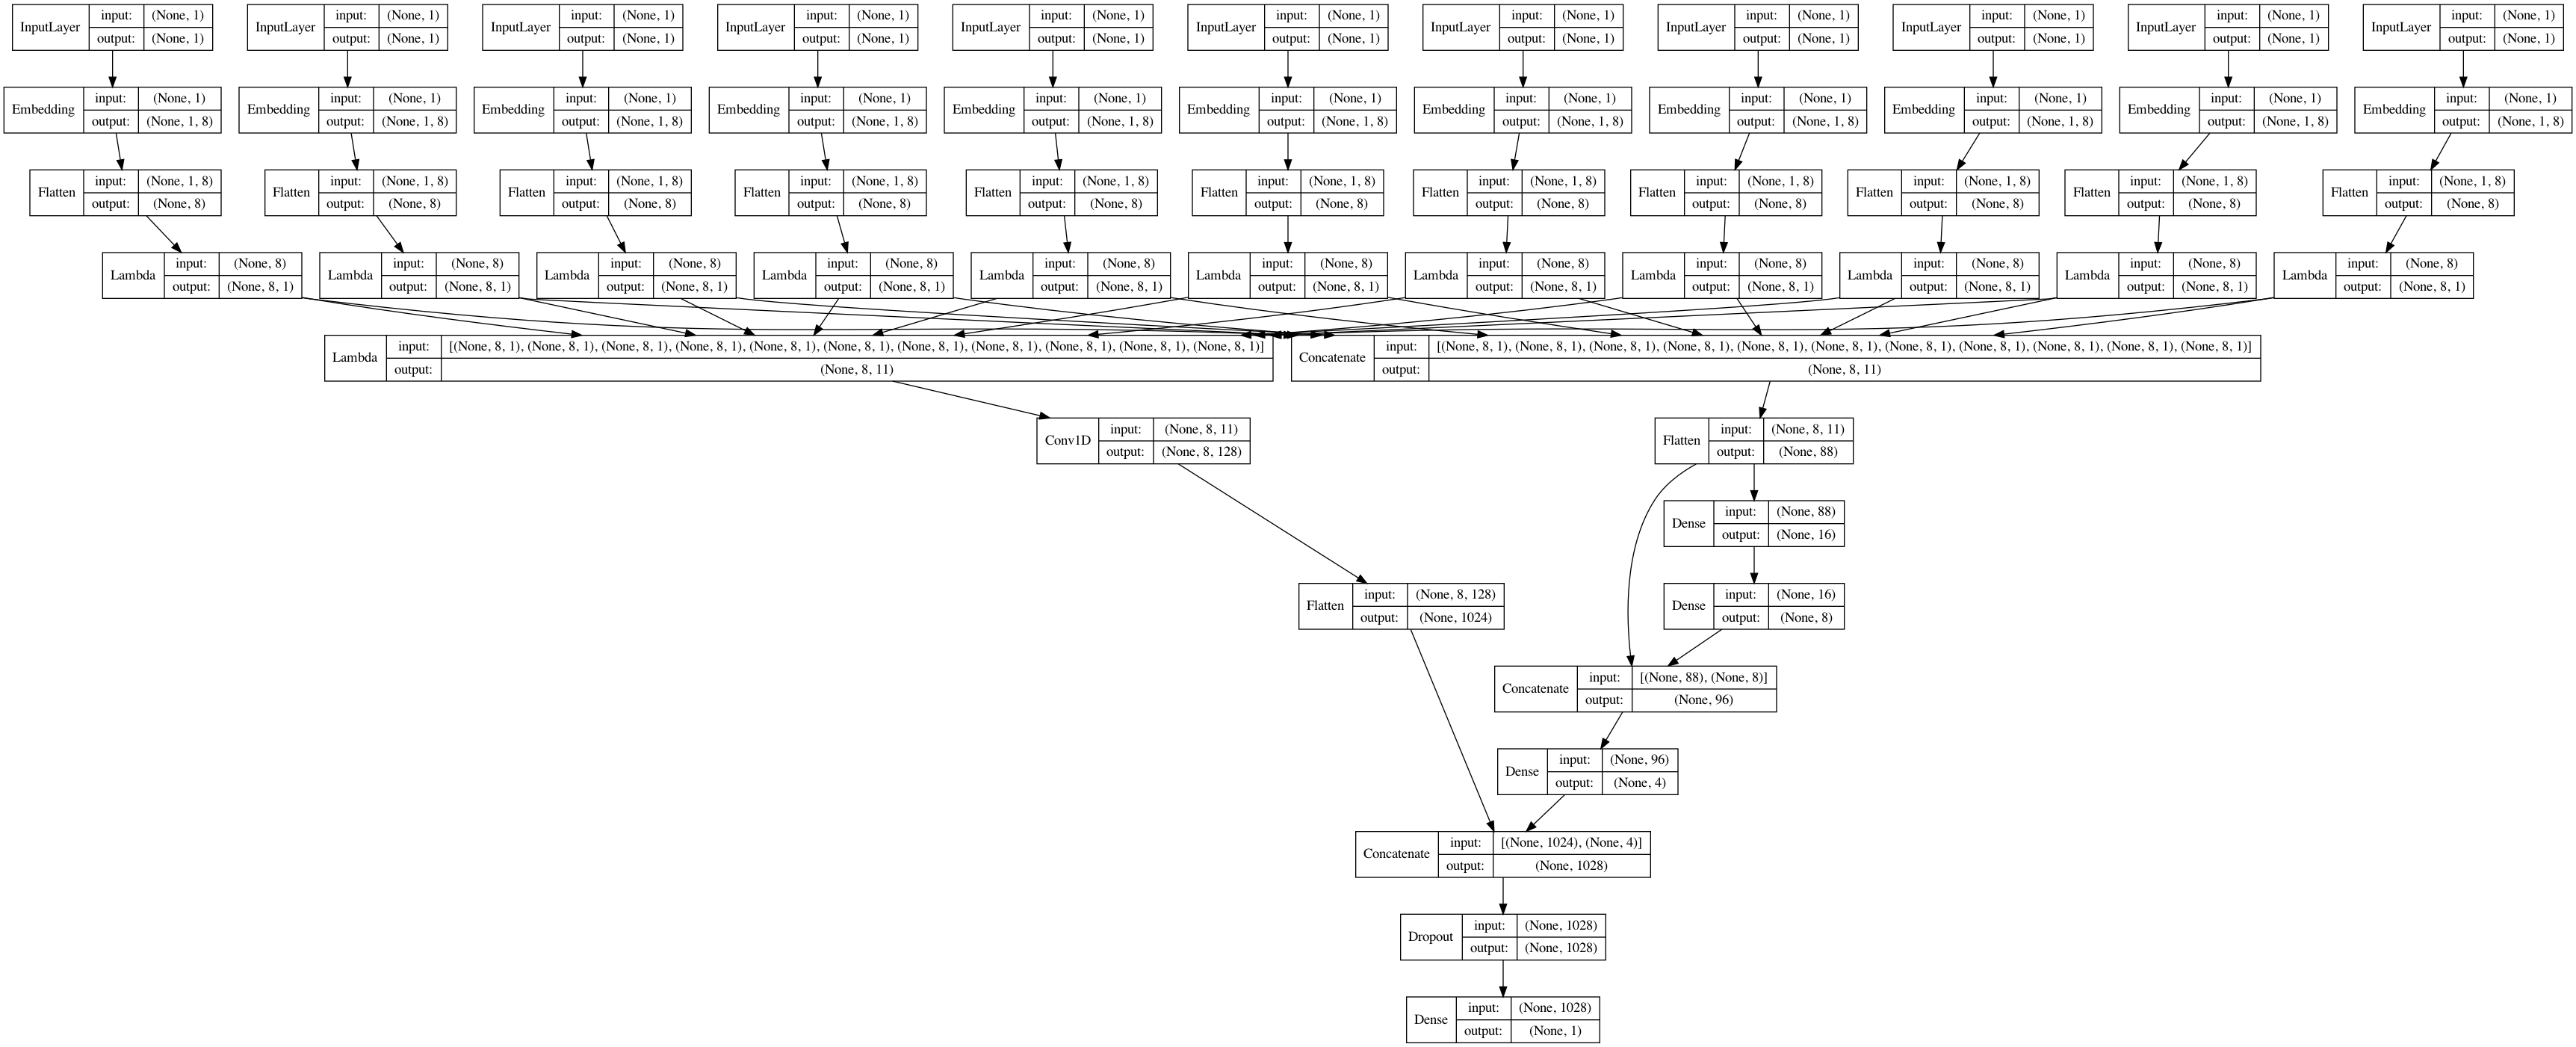

In [86]:
# Concatenate MF and MLP parts
predict_vector = Concatenate()([MF_part, mlp_concat])
predict_vector = Dropout(0.2)(predict_vector)

# Final prediction layer
prediction = Dense(1, name = "prediction")(predict_vector) # activation='sigmoid',
model = Model([userID, users_mean_rating, 
                             user_reviewcount, locationId, 
                             createdDate, photonum, fch, category_l, rated_count,
                                  average_photonum, average_rating], prediction)
model.compile(loss="mse", optimizer=RMSprop(lr=1e-4), metrics=[tf.keras.metrics.AUC()])

Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 68509 samples, validate on 345 samples
Epoch 1/20
68509/68509 [==============================] - 2s 26us/step - loss: 18.9704 - auc_1: 0.0000e+00 - val_loss: 18.9202 - val_auc_1: 0.0000e+00
Epoch 2/20
68509/68509 [==============================] - 1s 18us/step - loss: 18.3254 - auc_1: 0.0000e+00 - val_loss: 18.2785 - val_auc_1: 0.0000e+00
Epoch 3/20
68509/68509 [==============================] - 1s 18us/step - loss: 17.5576 - auc_1: 0.0000e+00 - val_loss: 17.4946 - val_auc_1: 0.0000e+00
Epoch 4/20
68509/68509 [==============================] - 1s 18us/step - loss: 16.6338 - auc_1: 0.0000e+00 - val_loss: 16.5614 - val_auc_1: 0.0000e+00
Epoch 5/20
68509/68509 [==============================] - 1s 17us/step - loss: 15.5464 - auc_1: 0.0000e+00 - val_loss: 15.4752 - val_auc_1: 0.0000e+00
Epoch 6/20
68509/68509 [==============================] - 1s 18us/step - loss: 14.3014 - auc_1: 0.0000e+00 - val_loss: 14.2441 - val_auc_1: 0.0000e+00
Epoch 7/20
68509/68509 [======================

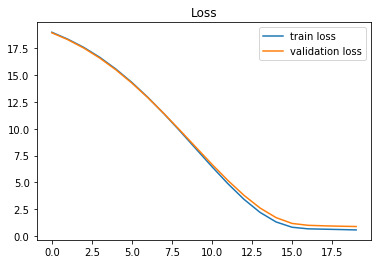

In [87]:
history = model.fit(x=[encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                       encoded_fch, encoded_category_l, encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating],
                    y=global_df['rating'], batch_size=2048, epochs=20, validation_split=0.005, verbose=1)

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss")
plt.show()

In [54]:
# # 모델 저장하기 
# model.save_weights(os.path.join("..","realtime_model",'wnd_global_model2.h5'))

# model_json = model.to_json()
# with open(os.path.join("..","realtime_model","wnd_global_model2.json"), "w") as json_file : 
#     json_file.write(model_json)
    
# print("Saved model to disk")

Saved model to disk


# item 유사도 반환

In [55]:
# # 모델 불러오기 
# from keras.models import model_from_json 
# json_file = open(os.path.join("..","realtime_model","wnd_global_model2.json"), "r") 
# loaded_model_json = json_file.read() 
# json_file.close() 

# loaded_model = model_from_json(loaded_model_json, custom_objects={'tf': tf, 'n_factors':8})

# loaded_model.load_weights(os.path.join("..","realtime_model","wnd_global_model2.h5"))
# print("Loaded model from disk")

Loaded model from disk


In [88]:
def latent_to_vec(feature, model, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']
    
    # 아이템별 의미 벡터 생성 
    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [89]:
vec = latent_to_vec('FM_locationId', model, global_df, 8, [encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                       encoded_fch, encoded_category_l, encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating])

In [90]:
vec.to_csv(os.path.join("..","realtime_model",'wnd_global_vec2.csv'))#, index=False)

vecs = pd.read_csv(os.path.join("..","realtime_model",'wnd_global_vec2.csv'))
vecs

,locationId,0,1,2,3,4,5,6,7
0,1500428988,0.042631,0.042631,0.042621,0.042621,0.042951,0.042951,0.041843,0.041843
1,1475741466,0.052881,0.052809,0.052706,0.052495,0.052422,0.052494,0.052628,0.052628
2,33880173,0.102209,0.102209,0.102209,0.102209,0.102209,0.102209,0.102209,0.102209
3,1517144962,0.045214,0.045214,0.045214,0.045214,0.044872,0.042675,0.042675,0.045044
4,1569821908,0.102209,0.102209,0.102209,0.102209,0.102209,0.102209,0.102209,0.102209
...,...,...,...,...,...,...,...,...,...
1431,7033805,0.024343,0.024343,0.024343,0.024343,0.024343,0.024343,0.024343,0.024343
1432,6643598,-0.011105,-0.011105,-0.011105,-0.011105,-0.011105,-0.011105,-0.011105,-0.011105
1433,8769938,0.010130,0.010130,0.010130,0.010130,0.010130,-0.011105,-0.011105,-0.011105
1434,10161356,0.042708,0.042708,0.042708,0.042708,0.042708,0.042708,0.042708,0.042708


In [91]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
import random

def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 


def sim_item(vec, df, item_id, top):
    top_id = cosim_id(df, vec, item_id)
    
    if type(top_id) == list :
        df = df.drop_duplicates(['locationId'], keep='last')
        recommend_rst = []
        for x in top_id:
            if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])

        print('input hotel:', df.loc[df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10)
        for i in range(len(recommend_rst[:top])):
            print('top', i+1, recommend_rst[i][0]['place.name'].values[0])
            print('  주소', recommend_rst[i][0]['land.addr'].values[0])
        
    else:
        answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
        x = random.randint(0, len(answer_lst)-1)
        return answer_lst[x]

데이터 업뎃 후

In [92]:
import random

for location_id in common_acm_ids[:10]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔에잇아워즈
----------
top 1 파이어벨 버거
  주소 서울특별시 강남구 대치동 908-17
top 2 삼육공
  주소 서울특별시 마포구 서교동 401-12
top 3 창신육회
  주소 서울특별시 종로구 종로4가 165-5 대동빌딩
top 4 빌리프커피로스터스
  주소 서울특별시 마포구 서교동 384-3
top 5 청시행
  주소 error
top 6 앤드히어
  주소 서울특별시 종로구 동숭동 31-14
top 7 장군주먹고기
  주소 서울특별시 강서구 공항동 72-20
top 8 정통삼계탕
  주소 서울특별시 종로구 수송동 129-1
top 9 을밀대 평양냉면
  주소 서울특별시 마포구 염리동 147-6
top 10 순희네빈대떡
  주소 서울특별시 종로구 종로5가 138-9
None



--------------------------------------------------
input hotel: 노보텔스위트앰배서더서울용산
----------
top 1 조박집
  주소 서울특별시 마포구 용강동 40-1
top 2 카페 카푸치노
  주소 서울특별시 강남구 논현동 206-1 호텔 카푸치노
top 3 명동정
  주소 서울특별시 중구 충무로2가 60-3 성창빌딩
top 4 피자 필
  주소 서울특별시 종로구 관철동 43-9
top 5 우촌 돌솥 설렁탕
  주소 서울특별시 중구 저동2가 10
top 6 성천막국수
  주소 서울특별시 동대문구 답십리동 265-1
top 7 낭만김밥
  주소 서울특별시 중구 명동1가 45-1
top 8 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 9 진상샤브샤브
  주소 서울특별시 강남구 청담동 87-1 담빌딩
top 10 베키아에누보 - 본점(신관4층)
  주소 서울특별시 중구 충무로1가 52-5 신세계백화점건물
None



--------------------------------------------------
input hotel: 오리엔스호텔&레지던스


In [93]:
import random

for location_id in common_acm_ids[10:20]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 롯데시티호텔 마포
----------
top 1 아르모니움
  주소 서울특별시 용산구 한남동 657-37
top 2 그릭조이
  주소 서울특별시 마포구 서교동 358-36 서교빌딩
top 3 골든치즈타르트
  주소 서울특별시 마포구 합정동 472 마포 한강 푸르지오
top 4 세종참치
  주소 서울특별시 중구 충무로2가 61-3 세종서적
top 5 Chakraa Indian Restaurant, Hannam, Seoul
  주소 error
top 6 운니사랑방
  주소 서울특별시 종로구 운니동 45-1
top 7 반타이
  주소 서울특별시 종로구 재동 94-1
top 8 안동국시
  주소 서울특별시 마포구 공덕동 105-137
top 9 두림
  주소 서울특별시 종로구 청진동 31-2
top 10 동영관
  주소 서울특별시 중구 정동 1-49
None



--------------------------------------------------
input hotel: 레스케이프 호텔
----------
top 1 마포만두
  주소 서울특별시 마포구 서교동 393-1
top 2 롯데리아
  주소 서울특별시 강남구 삼성동 159 코엑스
top 3 비스떼까
  주소 서울특별시 용산구 이태원동 211-33
top 4 트로이카
  주소 서울특별시 용산구 이태원동 119-29
top 5 두림
  주소 서울특별시 종로구 청진동 31-2
top 6 커피 방앗간
  주소 서울특별시 종로구 화동 102-1
top 7 하루연가
  주소 서울특별시 종로구 종로6가 103 야드인빌딩
top 8 연남서식당
  주소 서울특별시 마포구 노고산동 109-69
top 9 진미식당
  주소 서울특별시 마포구 공덕동 105-127 선화의원
top 10 란주라미엔
  주소 서울특별시 중구 충무로1가 25-9
None



--------------------------------------------------
input hotel: 티마크그랜드호텔 명동
---------

In [94]:
import random

for location_id in common_acm_ids[20:30]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 강남아르누보시티
----------
top 1 맥심플랜트
  주소 서울특별시 용산구 한남동 683-140
top 2 스시조
  주소 서울특별시 중구 소공동 87-1 서울 웨스틴조선호텔
top 3 랩24
  주소 서울특별시 강남구 신사동 643-1
top 4 동경스테이크
  주소 서울특별시 노원구 중계동 591 대호프라자
top 5 살롱 드 떼
  주소 서울특별시 중구 소공동 1 롯데호텔
top 6 공차
  주소 서울특별시 강남구 삼성동 159-8 파르나스타워
top 7 비바폴로 열매점
  주소 서울특별시 강동구 명일동 312-86
top 8 한국맥주거래소
  주소 서울특별시 영등포구 여의도동 44-35 제일빌딩
top 9 금해안
  주소 서울특별시 종로구 운니동 96
top 10 온달파전
  주소 서울특별시 동대문구 휘경동 319-31
None



--------------------------------------------------
input hotel: TheK호텔 서울
----------
top 1 장군주먹고기
  주소 서울특별시 강서구 공항동 72-20
top 2 파이어벨 버거
  주소 서울특별시 강남구 대치동 908-17
top 3 아따블르
  주소 서울특별시 종로구 팔판동 104-8
top 4 뜰안
  주소 서울특별시 종로구 익선동 166-76
top 5 삼육공
  주소 서울특별시 마포구 서교동 401-12
top 6 창신육회
  주소 서울특별시 종로구 종로4가 165-5 대동빌딩
top 7 서연황소곱창
  주소 서울특별시 서대문구 창천동 52-119
top 8 청시행
  주소 error
top 9 앤드히어
  주소 서울특별시 종로구 동숭동 31-14
top 10 카페 카푸치노
  주소 서울특별시 강남구 논현동 206-1 호텔 카푸치노
None



--------------------------------------------------
input hotel: 롯데시티호텔 구로
-

In [95]:
import random

for location_id in common_acm_ids[30:40]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 글래드 여의도
----------
top 1 진주회관
  주소 서울특별시 중구 서소문동 120-35
top 2 조박집
  주소 서울특별시 마포구 용강동 40-1
top 3 명동정
  주소 서울특별시 중구 충무로2가 60-3 성창빌딩
top 4 성천막국수
  주소 서울특별시 동대문구 답십리동 265-1
top 5 오설록티하우스
  주소 서울특별시 서초구 서초동 1328 홍우빌딩
top 6 카페 카푸치노
  주소 서울특별시 강남구 논현동 206-1 호텔 카푸치노
top 7 낭만김밥
  주소 서울특별시 중구 명동1가 45-1
top 8 피자 필
  주소 서울특별시 종로구 관철동 43-9
top 9 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 10 우촌 돌솥 설렁탕
  주소 서울특별시 중구 저동2가 10
None



--------------------------------------------------
input hotel: 더스테이트 선유 호텔
----------
top 1 트로이카
  주소 서울특별시 용산구 이태원동 119-29
top 2 진미식당
  주소 서울특별시 마포구 공덕동 105-127 선화의원
top 3 롯데리아
  주소 서울특별시 강남구 삼성동 159 코엑스
top 4 북스쿡스
  주소 서울특별시 종로구 가회동 177-4
top 5 장원각
  주소 서울특별시 중구 장충동2가 200-1
top 6 풀향기
  주소 서울특별시 용산구 한남동 726-54 풀향기(음식점)
top 7 스시조
  주소 서울특별시 중구 소공동 87-1 서울 웨스틴조선호텔
top 8 빌리엔젤케익컴퍼니
  주소 서울특별시 강남구 역삼동 675-3 KT영동지사, 신라 스테이호텔
top 9 멘야산다이메
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 10 왓어샐러드
  주소 서울특별시 용산구 이태원동 74-33
None



--------------------------------------------------
inp

In [96]:
import random

for location_id in common_acm_ids[40:50]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 나인트리프리미어호텔 명동2
----------
top 1 와플잇업
  주소 서울특별시 서대문구 대현동 27-17
top 2 육미
  주소 서울특별시 중구 다동 111 국제빌딩
top 3 민스키친
  주소 서울특별시 강남구 신사동 651-4
top 4 루트
  주소 서울특별시 용산구 한남동 741-19
top 5 전주콩나물국밥
  주소 서울특별시 동대문구 휘경동 191-5
top 6 구르카 인도 레스토랑
  주소 서울특별시 중구 명동2가 32-14
top 7 연남동돼지구이백반
  주소 서울특별시 마포구 연남동 260-28 계림빌딩
top 8 코너스톤, 파크 하얏트 서울
  주소 서울특별시 강남구 대치동 995-14 호텔아이파크(주)
top 9 Huggers
  주소 error
top 10 가메골손만두
  주소 서울특별시 중구 남창동 60-2
None



--------------------------------------------------
input hotel: 노보텔 앰배서더 서울 강남
----------
top 1 트로이카
  주소 서울특별시 용산구 이태원동 119-29
top 2 진미식당
  주소 서울특별시 마포구 공덕동 105-127 선화의원
top 3 롯데리아
  주소 서울특별시 강남구 삼성동 159 코엑스
top 4 북스쿡스
  주소 서울특별시 종로구 가회동 177-4
top 5 장원각
  주소 서울특별시 중구 장충동2가 200-1
top 6 풀향기
  주소 서울특별시 용산구 한남동 726-54 풀향기(음식점)
top 7 스시조
  주소 서울특별시 중구 소공동 87-1 서울 웨스틴조선호텔
top 8 빌리엔젤케익컴퍼니
  주소 서울특별시 강남구 역삼동 675-3 KT영동지사, 신라 스테이호텔
top 9 멘야산다이메
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 10 왓어샐러드
  주소 서울특별시 용산구 이태원동 74-33
None



-----------------------------------------

In [97]:
import random

for location_id in common_acm_ids[50:60]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 베스트웨스턴프리미어서울가든호텔
----------
top 1 개미집1
  주소 서울특별시 광진구 화양동 508-2
top 2 9 티모
  주소 서울특별시 용산구 이태원동 112-6
top 3 마장동한우촌
  주소 서울특별시 성동구 마장동 439-1 마축일축산물시장
top 4 소울 쿠키
  주소 서울특별시 마포구 창전동 2-48
top 5 삼육공
  주소 서울특별시 마포구 서교동 401-12
top 6 파이어벨 버거
  주소 서울특별시 강남구 대치동 908-17
top 7 뜰안
  주소 서울특별시 종로구 익선동 166-76
top 8 아따블르
  주소 서울특별시 종로구 팔판동 104-8
top 9 을지면옥
  주소 서울특별시 중구 입정동 177-1
top 10 정통삼계탕
  주소 서울특별시 종로구 수송동 129-1
None



--------------------------------------------------
input hotel: 머큐어 서울 앰배서더 강남 쏘도베
----------
top 1 소문난감자탕
  주소 서울특별시 성동구 성수동2가 315-100
top 2 송화산시도삭면
  주소 서울특별시 광진구 자양동 851-20
top 3 황소고집
  주소 서울특별시 종로구 관철동 11-11
top 4 시크릿가든
  주소 서울특별시 종로구 와룡동 69
top 5 광화문이층집
  주소 서울특별시 종로구 견지동 110 종로1가 대성 스카이렉스
top 6 빅세일
  주소 서울특별시 영등포구 여의도동 54-2 진주상가
top 7 순희네빈대떡
  주소 서울특별시 종로구 종로5가 138-9
top 8 낭만김밥
  주소 서울특별시 중구 명동1가 45-1
top 9 을밀대 평양냉면
  주소 서울특별시 마포구 염리동 147-6
top 10 미스터램
  주소 서울특별시 강남구 삼성동 166-5 홍선빌딩
None



--------------------------------------------------
input hotel: 명동멀린

In [98]:
import random

for location_id in common_acm_ids[60:70]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 오라카이 인사동 스위츠
----------
top 1 Uncle's Grilled Fish
  주소 서울특별시 중구 남창동 168-2
top 2 꽃 밥에피다
  주소 서울특별시 종로구 관훈동 118-27
top 3 부띠끄경성
  주소 서울특별시 종로구 팔판동 89
top 4 장군주먹고기
  주소 서울특별시 강서구 공항동 72-20
top 5 을지면옥
  주소 서울특별시 중구 입정동 177-1
top 6 당산원조곱창
  주소 서울특별시 영등포구 당산동5가 33-9 유경빌딩
top 7 파이어벨 버거
  주소 서울특별시 강남구 대치동 908-17
top 8 서울리즘
  주소 error
top 9 도림
  주소 서울특별시 중구 소공동 1 롯데호텔
top 10 뜰안
  주소 서울특별시 종로구 익선동 166-76
None



--------------------------------------------------
input hotel: 롯데시티호텔 명동
----------
top 1 소나무야
  주소 서울특별시 강남구 청담동 131-12
top 2 카페 연남동 239-20
  주소 서울특별시 마포구 연남동 239-20
top 3 더킹스
  주소 서울특별시 중구 신당동 432-1630 신당동 하이츠
top 4 일젤라또
  주소 서울특별시 강남구 신사동 550-9
top 5 맥애덤스 커피
  주소 서울특별시 종로구 운니동 43
top 6 아티제
  주소 서울특별시 강남구 역삼동 675-3 KT영동지사, 신라 스테이호텔
top 7 패스트리부티크
  주소 서울특별시 중구 장충동2가 202 신라호텔
top 8 경주 장모님미역국
  주소 서울특별시 성북구 성북동 124-14
top 9 명동할머니국수
  주소 서울특별시 종로구 관철동 37-2
top 10 풀향기
  주소 서울특별시 용산구 한남동 726-54 풀향기(음식점)
None



--------------------------------------------------
input hote

In [99]:
import random

for location_id in common_acm_ids[70:80]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 그라모스호텔
----------
top 1 이춘복참치
  주소 서울특별시 종로구 관철동 11-2
top 2 돼지집
  주소 서울특별시 중구 태평로2가 69-7 대영빌딩
top 3 낙원
  주소 서울특별시 강서구 외발산동 426 메이필드호텔
top 4 서연황소곱창
  주소 서울특별시 서대문구 창천동 52-119
top 5 도림
  주소 서울특별시 중구 소공동 1 롯데호텔
top 6 홍대돈부리
  주소 서울특별시 마포구 서교동 366-18
top 7 당산원조곱창
  주소 서울특별시 영등포구 당산동5가 33-9 유경빌딩
top 8 파로그랜드
  주소 서울특별시 중구 수하동 67 미래에셋 센터원(Mirae Asset CENTER1)
top 9 마장동한우촌
  주소 서울특별시 성동구 마장동 439-1 마축일축산물시장
top 10 부띠끄경성
  주소 서울특별시 종로구 팔판동 89
None



--------------------------------------------------
input hotel: MEASeoul
----------
top 1 소나무야
  주소 서울특별시 강남구 청담동 131-12
top 2 카페 연남동 239-20
  주소 서울특별시 마포구 연남동 239-20
top 3 더킹스
  주소 서울특별시 중구 신당동 432-1630 신당동 하이츠
top 4 일젤라또
  주소 서울특별시 강남구 신사동 550-9
top 5 맥애덤스 커피
  주소 서울특별시 종로구 운니동 43
top 6 아티제
  주소 서울특별시 강남구 역삼동 675-3 KT영동지사, 신라 스테이호텔
top 7 패스트리부티크
  주소 서울특별시 중구 장충동2가 202 신라호텔
top 8 경주 장모님미역국
  주소 서울특별시 성북구 성북동 124-14
top 9 명동할머니국수
  주소 서울특별시 종로구 관철동 37-2
top 10 풀향기
  주소 서울특별시 용산구 한남동 726-54 풀향기(음식점)
None



------------------------

In [100]:
import random

for location_id in common_acm_ids[80:90]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 토요코인 서울강남
----------
top 1 창신육회
  주소 서울특별시 종로구 종로4가 165-5 대동빌딩
top 2 앤드히어
  주소 서울특별시 종로구 동숭동 31-14
top 3 청시행
  주소 error
top 4 을밀대 평양냉면
  주소 서울특별시 마포구 염리동 147-6
top 5 피자 필
  주소 서울특별시 종로구 관철동 43-9
top 6 우촌 돌솥 설렁탕
  주소 서울특별시 중구 저동2가 10
top 7 정통삼계탕
  주소 서울특별시 종로구 수송동 129-1
top 8 진상샤브샤브
  주소 서울특별시 강남구 청담동 87-1 담빌딩
top 9 젠하이드어웨이 - 홍대
  주소 서울특별시 마포구 서교동 408-3
top 10 정원레스토랑 어반가든
  주소 서울특별시 중구 정동 28-2
None



--------------------------------------------------
input hotel: 호텔 아이린
----------
top 1 영암보리밥
  주소 서울특별시 종로구 종로5가 395-5
top 2 사과나무
  주소 서울특별시 종로구 관훈동 84-5
top 3 아시안 라이브
  주소 error
top 4 파리크라상
  주소 서울특별시 용산구 동자동 43-205 한국철도공사
top 5 툭툭누들타이
  주소 서울특별시 서대문구 연희동 353-89
top 6 커피어스
  주소 서울특별시 강남구 신사동 534-22
top 7 수제만두 국시각시
  주소 error
top 8 모노치즈
  주소 서울특별시 강남구 논현동 37-3
top 9 호수집
  주소 서울특별시 중구 중림동 61-4
top 10 델리카한스
  주소 서울특별시 중구 소공동 1 롯데호텔
None



--------------------------------------------------
input hotel: 퍼시픽호텔
----------
top 1 해도식당
  주소 서울특별시 중구 소공동 1 롯데백화점 본점
top 2 어바웃진스 바베큐 키친


In [101]:
import random

for location_id in common_acm_ids[90:100]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 시그니엘 서울
----------
top 1 고래불
  주소 서울특별시 강남구 역삼동 828-52
top 2 빌리프커피로스터스
  주소 서울특별시 마포구 서교동 384-3
top 3 정통삼계탕
  주소 서울특별시 종로구 수송동 129-1
top 4 성천막국수
  주소 서울특별시 동대문구 답십리동 265-1
top 5 삼육공
  주소 서울특별시 마포구 서교동 401-12
top 6 조박집
  주소 서울특별시 마포구 용강동 40-1
top 7 정원순두부
  주소 서울특별시 중구 서소문동 120-12
top 8 젠하이드어웨이 - 홍대
  주소 서울특별시 마포구 서교동 408-3
top 9 창신육회
  주소 서울특별시 종로구 종로4가 165-5 대동빌딩
top 10 개미집1
  주소 서울특별시 광진구 화양동 508-2
None



--------------------------------------------------
input hotel: 그랜드 인터컨티넨탈 서울 파르나스
----------
top 1 마조앤새디
  주소 서울특별시 강남구 청담동 22-1
top 2 앙카라 피크닉
  주소 서울특별시 용산구 이태원동 127-11
top 3 빵나무
  주소 서울특별시 마포구 동교동 201-48
top 4 알천생태찌개
  주소 서울특별시 송파구 잠실동 197-7 sms
top 5 일젤라또
  주소 서울특별시 강남구 신사동 550-9
top 6 목란
  주소 서울특별시 종로구 평동 26-10
top 7 패스트리부티크
  주소 서울특별시 중구 장충동2가 202 신라호텔
top 8 왓어샐러드
  주소 서울특별시 용산구 이태원동 74-33
top 9 명동할머니국수
  주소 서울특별시 종로구 관철동 37-2
top 10 스시홍
  주소 서울특별시 마포구 신공덕동 171 마포케이씨씨웰츠타워
None



--------------------------------------------------
input hotel: 노보텔 앰배서더 

In [102]:
import random

for location_id in common_acm_ids[100:110]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 나포레
----------
top 1 교토마블
  주소 서울특별시 용산구 용산동5가 24-1 파크타워아파트
top 2 빌리엔젤케익컴퍼니
  주소 서울특별시 강남구 역삼동 675-3 KT영동지사, 신라 스테이호텔
top 3 베이스
  주소 서울특별시 강남구 역삼동 826-3
top 4 한우리 한정식
  주소 서울특별시 강남구 논현동 91-4 코오라빌딩
top 5 청담로스
  주소 서울특별시 강남구 청담동 131-14
top 6 코바치
  주소 서울특별시 중구 회현동2가 88 스테이트타워 남산
top 7 대장금
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 8 피그인더가든
  주소 서울특별시 영등포구 여의도동 23-5 한화손해보험빌딩
top 9 맥심플랜트
  주소 서울특별시 용산구 한남동 683-140
top 10 카페 연남동 239-20
  주소 서울특별시 마포구 연남동 239-20
None



--------------------------------------------------
input hotel: 세종 호텔
----------
top 1 원조한치
  주소 서울특별시 중구 명동1가 44-3
top 2 미스터램
  주소 서울특별시 강남구 삼성동 166-5 홍선빌딩
top 3 철길왕갈비살
  주소 서울특별시 마포구 창전동 4-2
top 4 왓어샐러드
  주소 서울특별시 용산구 이태원동 74-33
top 5 나무가있는집
  주소 서울특별시 종로구 신문로2가 1-209
top 6 낭만김밥
  주소 서울특별시 중구 명동1가 45-1
top 7 안동찜닭
  주소 서울특별시 중구 충무로2가 66-4
top 8 도마
  주소 서울특별시 종로구 관훈동 15-1
top 9 북스쿡스
  주소 서울특별시 종로구 가회동 177-4
top 10 마포만두
  주소 서울특별시 마포구 서교동 393-1
None



--------------------------------------------------
input hotel:

In [103]:
import random

for location_id in common_acm_ids[110:120]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 플로라 호텔신신 서울 명동
----------
top 1 단스시
  주소 서울특별시 강남구 논현동 238 쿠쿠빌딩
top 2 The View
  주소 error
top 3 멘야산다이메
  주소 서울특별시 마포구 서교동 355-25
top 4 오월의종
  주소 서울특별시 용산구 한남동 737-2
top 5 맥심플랜트
  주소 서울특별시 용산구 한남동 683-140
top 6 스시조
  주소 서울특별시 중구 소공동 87-1 서울 웨스틴조선호텔
top 7 김돈이
  주소 서울특별시 강남구 삼성동 140-29
top 8 호박식당
  주소 서울특별시 용산구 한남동 657-85
top 9 이니스프리 그린카페
  주소 서울특별시 중구 명동1가 65-2
top 10 멘야산다이메
  주소 서울특별시 양천구 목동 917-9 현대41타워
None



--------------------------------------------------
input hotel: 더 플라자
----------
top 1 피자 필
  주소 서울특별시 종로구 관철동 43-9
top 2 우촌 돌솥 설렁탕
  주소 서울특별시 중구 저동2가 10
top 3 카페 카푸치노
  주소 서울특별시 강남구 논현동 206-1 호텔 카푸치노
top 4 낭만김밥
  주소 서울특별시 중구 명동1가 45-1
top 5 원조한치
  주소 서울특별시 중구 명동1가 44-3
top 6 진상샤브샤브
  주소 서울특별시 강남구 청담동 87-1 담빌딩
top 7 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 8 미스터램
  주소 서울특별시 강남구 삼성동 166-5 홍선빌딩
top 9 철길왕갈비살
  주소 서울특별시 마포구 창전동 4-2
top 10 왓어샐러드
  주소 서울특별시 용산구 이태원동 74-33
None



--------------------------------------------------
input hotel: 아이비 빌 게스트하우스
----------
top 1 콩

In [104]:
import random

for location_id in common_acm_ids[120:130]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 이비스 버젯 앰배서더 서울 동대문
----------
top 1 이니스프리 그린카페
  주소 서울특별시 중구 명동1가 65-2
top 2 이성당카페
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 3 임피리얼팰리스 패밀리아
  주소 서울특별시 강남구 논현동 248-7 임피리얼 팰리스호텔
top 4 아티제
  주소 서울특별시 강남구 역삼동 675-3 KT영동지사, 신라 스테이호텔
top 5 북촌빙수
  주소 서울특별시 종로구 팔판동 64
top 6 하단
  주소 서울특별시 성북구 성북동 184-40
top 7 마포만두
  주소 서울특별시 마포구 서교동 393-1
top 8 스위치 플래닛
  주소 서울특별시 강남구 논현동 118-1
top 9 맥심플랜트
  주소 서울특별시 용산구 한남동 683-140
top 10 로비라운지바
  주소 서울특별시 구로구 신도림동 692 디큐브시티
None



--------------------------------------------------
input hotel: 호텔 코지 명동
----------
top 1 다담
  주소 서울특별시 강남구 청담동 97-1 M빌딩
top 2 WXYZ바
  주소 서울특별시 중구 명동2가 104
top 3 북촌빙수
  주소 서울특별시 종로구 팔판동 64
top 4 김돈이
  주소 서울특별시 강남구 삼성동 140-29
top 5 하루연가
  주소 서울특별시 종로구 종로6가 103 야드인빌딩
top 6 마포만두
  주소 서울특별시 마포구 서교동 393-1
top 7 원더브레드
  주소 서울특별시 중구 충무로2가 48-1
top 8 더 플라잉 팬 화이트
  주소 서울특별시 강남구 신사동 540-22
top 9 오크룸
  주소 서울특별시 중구 남대문로5가 395 힐튼호텔
top 10 마지
  주소 서울특별시 종로구 체부동 132-1
None



--------------------------------------------------
input hote

In [105]:
import random

for location_id in common_acm_ids[130:140]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 케이팝 레지던스 명동 1
----------
top 1 그안
  주소 서울특별시 중구 장충동2가 190-10 디자인하우스
top 2 모찌
  주소 서울특별시 용산구 이태원동 126-7
top 3 웰빙한식부페
  주소 서울특별시 서대문구 창천동 503-16
top 4 대박집
  주소 error
top 5 북스쿡스
  주소 서울특별시 종로구 가회동 177-4
top 6 다모토리
  주소 서울특별시 용산구 용산동2가 44-18
top 7 더델리
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 8 빠리가옥
  주소 서울특별시 종로구 익선동 166-26
top 9 인굿컴퍼니
  주소 서울특별시 강남구 신사동 554-3
top 10 앤아더
  주소 서울특별시 성동구 성수동1가 668-104
None



--------------------------------------------------
input hotel: 호텔더디자이너스 디디피
----------
top 1 닥터 플라토
  주소 서울특별시 송파구 방이동 204
top 2 C27
  주소 서울특별시 강남구 신사동 545-12
top 3 라따블
  주소 서울특별시 중구 명동1가 59-5 명동 토투앤,엠버서더호텔
top 4 서울 베이킹 컴퍼니 - JW 메리어트 동대문 스퀘어 서울
  주소 서울특별시 종로구 종로6가 289-3
top 5 모모야마
  주소 서울특별시 중구 소공동 1 롯데호텔
top 6 리틀 사이공
  주소 서울특별시 강서구 방화동 886 김포공항, 롯데몰, 스카이시티
top 7 BLT 스테이크
  주소 서울특별시 종로구 종로6가 289-3
top 8 봉화묵집
  주소 서울특별시 성북구 정릉동 488-1
top 9 카페 공드리
  주소 서울특별시 종로구 계동 140-23
top 10 진미평양냉면
  주소 서울특별시 강남구 논현동 115-10
None



--------------------------------------------------
input hotel:

In [106]:
import random

for location_id in common_acm_ids[140:150]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 현대레지던스
----------
top 1 명화원
  주소 서울특별시 용산구 한강로1가 14-28
top 2 남북통일
  주소 서울특별시 마포구 서교동 375-26
top 3 채근담
  주소 서울특별시 강남구 대치동 983 태범빌딩
top 4 하남돼지집
  주소 서울특별시 서초구 양재동 351-3
top 5 아키라백 서울
  주소 서울특별시 종로구 당주동 30
top 6 신고집 찜칼국수
  주소 서울특별시 노원구 하계동 209-2 L씨 빌딩
top 7 학림다방
  주소 서울특별시 종로구 명륜4가 94-2
top 8 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 9 도마
  주소 서울특별시 종로구 관훈동 15-1
top 10 Korean BBQ House Raon
  주소 error
None



--------------------------------------------------
input hotel: 호텔 통 비바체 동대문
----------
top 1 장원각
  주소 서울특별시 중구 장충동2가 200-1
top 2 인사동 수제비
  주소 서울특별시 종로구 관훈동 29-2
top 3 레스토랑 오늘
  주소 서울특별시 용산구 동빙고동 1-102 행복나눔재단
top 4 용수산
  주소 서울특별시 종로구 삼청동 118-3 용수산
top 5 정식당
  주소 서울특별시 강남구 청담동 83-24
top 6 명동한식당
  주소 서울특별시 종로구 인사동 92
top 7 미스터램
  주소 서울특별시 강남구 삼성동 166-5 홍선빌딩
top 8 트로이카
  주소 서울특별시 용산구 이태원동 119-29
top 9 원조 갈치조림 중앙식당
  주소 서울특별시 중구 남창동 34-37
top 10 명화원
  주소 서울특별시 용산구 한강로1가 14-28
None



--------------------------------------------------
input hotel: 그리드인호텔
----------
top 1 창신육회
  주소 

In [107]:
import random

for location_id in common_acm_ids[150:160]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 아띠 충무로
----------
top 1 영암보리밥
  주소 서울특별시 종로구 종로5가 395-5
top 2 살롱 드 떼
  주소 서울특별시 중구 소공동 1 롯데호텔
top 3 북스쿡스
  주소 서울특별시 종로구 가회동 177-4
top 4 빈스빈스
  주소 서울특별시 서대문구 대현동 56-126
top 5 대박집
  주소 error
top 6 코벤트가든
  주소 서울특별시 송파구 방이동 171 올림픽베어스타운
top 7 쿠이신보
  주소 서울특별시 마포구 합정동 413-16
top 8 골든치즈타르트
  주소 서울특별시 마포구 합정동 472 마포 한강 푸르지오
top 9 Chakraa Indian Restaurant, Hannam, Seoul
  주소 error
top 10 운니사랑방
  주소 서울특별시 종로구 운니동 45-1
None



--------------------------------------------------
input hotel: 호텔 도마
----------
top 1 명화원
  주소 서울특별시 용산구 한강로1가 14-28
top 2 남북통일
  주소 서울특별시 마포구 서교동 375-26
top 3 채근담
  주소 서울특별시 강남구 대치동 983 태범빌딩
top 4 하남돼지집
  주소 서울특별시 서초구 양재동 351-3
top 5 아키라백 서울
  주소 서울특별시 종로구 당주동 30
top 6 신고집 찜칼국수
  주소 서울특별시 노원구 하계동 209-2 L씨 빌딩
top 7 학림다방
  주소 서울특별시 종로구 명륜4가 94-2
top 8 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 9 도마
  주소 서울특별시 종로구 관훈동 15-1
top 10 Korean BBQ House Raon
  주소 error
None



--------------------------------------------------
input hotel: 스타즈 호텔 명동 II
----------
top 1 명동

In [108]:
import random

for location_id in common_acm_ids[160:170]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 콘래드 서울
----------
top 1 명동만두
  주소 서울특별시 은평구 불광동 310-11 연서시장
top 2 농민백암왕순대
  주소 서울특별시 강남구 역삼동 830-9
top 3 쉐라톤디큐브시티호텔FEAST
  주소 서울특별시 구로구 신도림동 692 디큐브시티
top 4 켄로쿠우동
  주소 서울특별시 중구 충무로1가 22-13
top 5 곤드레 딱주기
  주소 서울특별시 성북구 동소문동1가 5
top 6 페트라
  주소 서울특별시 용산구 이태원동 552
top 7 빈스빈스
  주소 서울특별시 마포구 공덕동 461 마포신영지웰
top 8 아따블르
  주소 서울특별시 종로구 팔판동 104-8
top 9 만원집
  주소 서울특별시 중구 충무로3가 30-3
top 10 포엠
  주소 서울특별시 중구 명동2가 54-7
None



--------------------------------------------------
input hotel: 포 포인츠 바이 쉐라톤 서울 남산
----------
top 1 을밀대 평양냉면
  주소 서울특별시 마포구 염리동 147-6
top 2 서교가든
  주소 서울특별시 마포구 서교동 466-1
top 3 곰국시집
  주소 서울특별시 중구 무교동 12-1
top 4 오가와
  주소 서울특별시 종로구 당주동 5 로얄빌딩
top 5 죠티인도레스토랑
  주소 서울특별시 마포구 노고산동 31-4
top 6 트라토리아 챠오
  주소 서울특별시 마포구 상수동 327-1
top 7 더로지
  주소 서울특별시 중구 을지로5가 273-4 트레블로지 동대문 호텔
top 8 종로제면소
  주소 서울특별시 종로구 묘동 156-1
top 9 베이스
  주소 서울특별시 강남구 역삼동 826-3
top 10 마포만두
  주소 서울특별시 중구 충무로3가 25-18
None



--------------------------------------------------
input hotel: 쉐라톤 서울 디큐브 시티 호텔
-----

In [109]:
import random

for location_id in common_acm_ids[170:180]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 비스타 워커힐 서울
----------
top 1 명화원
  주소 서울특별시 용산구 한강로1가 14-28
top 2 남북통일
  주소 서울특별시 마포구 서교동 375-26
top 3 채근담
  주소 서울특별시 강남구 대치동 983 태범빌딩
top 4 하남돼지집
  주소 서울특별시 서초구 양재동 351-3
top 5 아키라백 서울
  주소 서울특별시 종로구 당주동 30
top 6 신고집 찜칼국수
  주소 서울특별시 노원구 하계동 209-2 L씨 빌딩
top 7 학림다방
  주소 서울특별시 종로구 명륜4가 94-2
top 8 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 9 도마
  주소 서울특별시 종로구 관훈동 15-1
top 10 Korean BBQ House Raon
  주소 error
None



--------------------------------------------------
input hotel: 임피리얼 팰리스 서울
----------
top 1 리틀 사이공
  주소 서울특별시 강서구 방화동 886 김포공항, 롯데몰, 스카이시티
top 2 BLT 스테이크
  주소 서울특별시 종로구 종로6가 289-3
top 3 라따블
  주소 서울특별시 중구 명동1가 59-5 명동 토투앤,엠버서더호텔
top 4 서울 베이킹 컴퍼니 - JW 메리어트 동대문 스퀘어 서울
  주소 서울특별시 종로구 종로6가 289-3
top 5 모모야마
  주소 서울특별시 중구 소공동 1 롯데호텔
top 6 좋은세상만들기
  주소 서울특별시 영등포구 양평동4가 281 르네상스 한강 오피스텔
top 7 을지 오비베어
  주소 서울특별시 중구 을지로3가 95-4
top 8 제이드가든
  주소 서울특별시 중구 을지로2가 195-8 와이즈빌딩
top 9 명동부대찌개
  주소 서울특별시 중구 명동1가 54-7
top 10 목란
  주소 서울특별시 서대문구 연희동 132-28
None



--------------------------------

In [110]:
import random

for location_id in common_acm_ids[180:190]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 노보텔 앰배서더 독산
----------
top 1 소나무야
  주소 서울특별시 강남구 청담동 131-12
top 2 카페 연남동 239-20
  주소 서울특별시 마포구 연남동 239-20
top 3 더킹스
  주소 서울특별시 중구 신당동 432-1630 신당동 하이츠
top 4 일젤라또
  주소 서울특별시 강남구 신사동 550-9
top 5 맥애덤스 커피
  주소 서울특별시 종로구 운니동 43
top 6 아티제
  주소 서울특별시 강남구 역삼동 675-3 KT영동지사, 신라 스테이호텔
top 7 패스트리부티크
  주소 서울특별시 중구 장충동2가 202 신라호텔
top 8 경주 장모님미역국
  주소 서울특별시 성북구 성북동 124-14
top 9 명동할머니국수
  주소 서울특별시 종로구 관철동 37-2
top 10 풀향기
  주소 서울특별시 용산구 한남동 726-54 풀향기(음식점)
None



--------------------------------------------------
input hotel: 데이즈 호텔 명동
----------
top 1 교토마블
  주소 서울특별시 용산구 용산동5가 24-1 파크타워아파트
top 2 창고43
  주소 서울특별시 강남구 논현동 85 BOB빌딩
top 3 서교가든
  주소 서울특별시 마포구 서교동 466-1
top 4 베이스
  주소 서울특별시 강남구 역삼동 826-3
top 5 한우리 한정식
  주소 서울특별시 강남구 논현동 91-4 코오라빌딩
top 6 청담로스
  주소 서울특별시 강남구 청담동 131-14
top 7 코바치
  주소 서울특별시 중구 회현동2가 88 스테이트타워 남산
top 8 대장금
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 9 피그인더가든
  주소 서울특별시 영등포구 여의도동 23-5 한화손해보험빌딩
top 10 스시홍
  주소 서울특별시 마포구 신공덕동 171 마포케이씨씨웰츠타워
None



-----------------

In [111]:
import random

for location_id in common_acm_ids[190:200]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 에이퍼스트호텔 명동
----------
top 1 명화원
  주소 서울특별시 용산구 한강로1가 14-28
top 2 남북통일
  주소 서울특별시 마포구 서교동 375-26
top 3 채근담
  주소 서울특별시 강남구 대치동 983 태범빌딩
top 4 하남돼지집
  주소 서울특별시 서초구 양재동 351-3
top 5 아키라백 서울
  주소 서울특별시 종로구 당주동 30
top 6 신고집 찜칼국수
  주소 서울특별시 노원구 하계동 209-2 L씨 빌딩
top 7 학림다방
  주소 서울특별시 종로구 명륜4가 94-2
top 8 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 9 도마
  주소 서울특별시 종로구 관훈동 15-1
top 10 Korean BBQ House Raon
  주소 error
None



--------------------------------------------------
input hotel: 더안 호스텔
----------
top 1 좋은세상만들기
  주소 서울특별시 영등포구 양평동4가 281 르네상스 한강 오피스텔
top 2 을지 오비베어
  주소 서울특별시 중구 을지로3가 95-4
top 3 목란
  주소 서울특별시 서대문구 연희동 132-28
top 4 이태리총각
  주소 서울특별시 종로구 통인동 137-7
top 5 서울 베이킹 컴퍼니 - JW 메리어트 동대문 스퀘어 서울
  주소 서울특별시 종로구 종로6가 289-3
top 6 라따블
  주소 서울특별시 중구 명동1가 59-5 명동 토투앤,엠버서더호텔
top 7 BLT 스테이크
  주소 서울특별시 종로구 종로6가 289-3
top 8 카페 공드리
  주소 서울특별시 종로구 계동 140-23
top 9 차이야기
  주소 서울특별시 종로구 관훈동 29-12
top 10 봉화묵집
  주소 서울특별시 성북구 정릉동 488-1
None



--------------------------------------------------
input hot

In [112]:
import random

for location_id in common_acm_ids[200:210]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 그랜드 앰배서더 서울 어소시에이티드 풀만 호텔
----------
top 1 아티제
  주소 서울특별시 강남구 역삼동 675-3 KT영동지사, 신라 스테이호텔
top 2 피에르 가니에르 서울
  주소 서울특별시 중구 소공동 1 롯데백화점 본점
top 3 마포만두
  주소 서울특별시 마포구 서교동 393-1
top 4 일젤라또
  주소 서울특별시 강남구 신사동 550-9
top 5 마더린러 베이글
  주소 서울특별시 서대문구 대현동 56-23
top 6 더델리
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 7 오월의종
  주소 서울특별시 용산구 한남동 737-2
top 8 영암보리밥
  주소 서울특별시 종로구 종로5가 395-5
top 9 쯔쿠시
  주소 서울특별시 용산구 남영동 89-5
top 10 북치구장구치구
  주소 서울특별시 종로구 인사동 2
None



--------------------------------------------------
input hotel: 호텔 크레센도 서울 매니지드 바이 아코르&앰배서더
----------
top 1 영암보리밥
  주소 서울특별시 종로구 종로5가 395-5
top 2 오장동 흥남집
  주소 서울특별시 중구 오장동 101-7 흥남집
top 3 유메스시
  주소 서울특별시 강서구 내발산동 646-2
top 4 공차
  주소 서울특별시 강남구 삼성동 159-8 파르나스타워
top 5 살롱 드 떼
  주소 서울특별시 중구 소공동 1 롯데호텔
top 6 랩24
  주소 서울특별시 강남구 신사동 643-1
top 7 툇마루집 된장예술
  주소 서울특별시 종로구 인사동 4
top 8 워킹 온 더 클라우드
  주소 서울특별시 영등포구 여의도동 60 63한화생명빌딩
top 9 Tartine Too
  주소 error
top 10 운니사랑방
  주소 서울특별시 종로구 운니동 45-1
None



--------------------------------------------

In [113]:
import random

for location_id in common_acm_ids[210:220]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 페이토 삼성
----------
top 1 토속촌삼계탕
  주소 서울특별시 종로구 체부동 85-1 토속촌
top 2 진미식당
  주소 서울특별시 마포구 공덕동 105-127 선화의원
top 3 북촌빙수
  주소 서울특별시 종로구 팔판동 64
top 4 어니언
  주소 서울특별시 성동구 성수동2가 277-135
top 5 카페 클로리스
  주소 서울특별시 마포구 서교동 358-18 상상사진관
top 6 명화원
  주소 서울특별시 용산구 한강로1가 14-28
top 7 장원각
  주소 서울특별시 중구 장충동2가 200-1
top 8 명동한식당
  주소 서울특별시 종로구 인사동 92
top 9 투스카니
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 10 채근담
  주소 서울특별시 강남구 대치동 983 태범빌딩
None



--------------------------------------------------
input hotel: 아벤트리 호텔 종로
----------
top 1 갓덴스시
  주소 서울특별시 종로구 관철동 19-1 해덕빌딩
top 2 김약국 커피 로스터스
  주소 서울특별시 용산구 효창동 74
top 3 9 티모
  주소 서울특별시 용산구 이태원동 112-6
top 4 서래갈매기
  주소 서울특별시 중구 필동3가 12-1
top 5 타이거타이거
  주소 서울특별시 종로구 권농동 171-6
top 6 서울리즘
  주소 error
top 7 뜰안
  주소 서울특별시 종로구 익선동 166-76
top 8 을지면옥
  주소 서울특별시 중구 입정동 177-1
top 9 파이어벨 버거
  주소 서울특별시 강남구 대치동 908-17
top 10 창덕궁
  주소 서울특별시 종로구 묘동 160-1
None



--------------------------------------------------
input hotel: 에이메스 호텔
----------
top 1 마조앤새디
  주소 서울특별시 강남구 청담동 22-1

In [114]:
import random

for location_id in common_acm_ids[220:230]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 뉴월드호텔
----------
top 1 오크룸
  주소 서울특별시 중구 남대문로5가 395 힐튼호텔
top 2 롯데리아
  주소 서울특별시 강남구 삼성동 159 코엑스
top 3 명동할머니국수
  주소 서울특별시 종로구 관철동 37-2
top 4 이니스프리 그린카페
  주소 서울특별시 중구 명동1가 65-2
top 5 던킨 도너츠 서울스퀘어
  주소 서울특별시 중구 남대문로5가 541-1
top 6 매드후라이치킨
  주소 서울특별시 강남구 도곡동 411-14 유일빌딩
top 7 하루연가
  주소 서울특별시 종로구 종로6가 103 야드인빌딩
top 8 파크카페
  주소 서울특별시 영등포구 여의도동 28-3 여의도파크센터
top 9 제주돈사돈
  주소 서울특별시 마포구 합정동 426-5
top 10 류니끄
  주소 서울특별시 강남구 신사동 520-1
None



--------------------------------------------------
input hotel: 호스텔 코리아 11th - 창덕궁
----------
top 1 영암보리밥
  주소 서울특별시 종로구 종로5가 395-5
top 2 고고스2
  주소 서울특별시 마포구 서교동 407-3
top 3 스미스가 좋아하는 한옥
  주소 서울특별시 종로구 사간동 62-1
top 4 루나리치
  주소 서울특별시 강남구 대치동 604 대치상가
top 5 무화잠
  주소 서울특별시 강남구 신사동 587-14 동현빌딩
top 6 더 플라잉 팬 화이트
  주소 서울특별시 강남구 신사동 540-22
top 7 코요테살룬
  주소 서울특별시 중구 남대문로5가 526 대우재단빌딩
top 8 파리크라상
  주소 서울특별시 용산구 동자동 43-205 한국철도공사
top 9 예티
  주소 서울특별시 마포구 서교동 360-22
top 10 페스타 바이 민구
  주소 서울특별시 중구 쌍림동 88-9
None



------------------------------------------------

In [115]:
import random

for location_id in common_acm_ids[230:240]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 골드리버호텔
----------
top 1 샤오롱티
  주소 서울특별시 종로구 누하동 1-25
top 2 더 플라잉 팬 화이트
  주소 서울특별시 강남구 신사동 540-22
top 3 소나무야
  주소 서울특별시 강남구 청담동 131-12
top 4 로비라운지바
  주소 서울특별시 구로구 신도림동 692 디큐브시티
top 5 안도
  주소 서울특별시 용산구 한남동 736-8
top 6 더 팀버 하우스, 파크 하얏트 서울
  주소 서울특별시 강남구 대치동 995-14 호텔아이파크(주)
top 7 하단
  주소 서울특별시 성북구 성북동 184-40
top 8 노들강
  주소 서울특별시 강남구 논현동 184-18
top 9 벽제 갈비
  주소 서울특별시 서대문구 창천동 13-20
top 10 일일향
  주소 서울특별시 강남구 신사동 601-3
None



--------------------------------------------------
input hotel: 도미인 서울 강남
----------
top 1 영암보리밥
  주소 서울특별시 종로구 종로5가 395-5
top 2 페스타 바이 민구
  주소 서울특별시 중구 쌍림동 88-9
top 3 무화잠
  주소 서울특별시 강남구 신사동 587-14 동현빌딩
top 4 고고스2
  주소 서울특별시 마포구 서교동 407-3
top 5 뜨리앙
  주소 서울특별시 강남구 청담동 81-7
top 6 코요테살룬
  주소 서울특별시 중구 남대문로5가 526 대우재단빌딩
top 7 파리크라상
  주소 서울특별시 용산구 동자동 43-205 한국철도공사
top 8 숨카페
  주소 서울특별시 구로구 구로동 191-7 에이스테크노타워8차
top 9 커피어스
  주소 서울특별시 강남구 신사동 534-22
top 10 용문집
  주소 서울특별시 성동구 마장동 818 현대아파트
None



--------------------------------------------------
input hotel: 오목교 

In [60]:
sim_item(vec, global_df, 3477158, 10)

input hotel: Conrad Seoul
----------
top 1 테이블15
  주소 서울 양화로6길 39
top 2 김밥나라
  주소 서울 율곡로 290-2
top 3 뜨리앙
  주소 서울 강남구 도산대로67길 30
top 4 호수집
  주소 서울 중구 청파로 443
top 5 죠티인도레스토랑
  주소 서울 서애로 12-4
top 6 더하우스1932
  주소 서울 중구 만리재로35길 5
top 7 카페코수이
  주소 서울 종로구 자하문로9길 14
top 8 322소월로-카우리
  주소 서울 용산구 소월로 322 그랜드 하얏트 서울 LL층
top 9 스시홍
  주소 서울 백범로 202
top 10 루브리카
  주소 서울 중구 소공로 106 서울 웨스틴조선호텔 저층 로비


In [61]:
sim_item(vec, global_df, 0, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.'

In [62]:
sim_item(vec, global_df, 299533, 10)

input hotel: ibis styles Ambassador Seoul Gangnam
----------
top 1 쭈꾸미불고기
  주소 서울 필동1가 3-20
top 2 빌리프커피로스터스
  주소 서울 마포구 양화로11길 50
top 3 오세계향
  주소 서울 종로구 인사동12길 14-5
top 4 화목순대국
  주소 서울 영등포구 여의도동 44-14  경도상가 1층 1F, Gyeongdo Sangga
top 5 보버 라운지
  주소 서울 중구 퇴계로 100 스테이트타워 1F
top 6 툇마루집 된장예술
  주소 서울 종로구 인사동4길 5-26 중원빌딩 2층
top 7 마포궁중족발
  주소 서울 만리재로 19
top 8 투스카니
  주소 서울 중구 소공로 119 플라자 호텔 2층
top 9 더김치찌개
  주소 서울 아차산로 395
top 10 소담채
  주소 서울 서초구 원지동 419-1 2층


In [63]:
sim_item(vec, global_df, 299152, 10)

input hotel: Best Western Premier Seoul Garden Hotel
----------
top 1 내림손 삼계탕
  주소 서울 중구 명동9길 16
top 2 공릉닭한마리
  주소 서울 서대문구 연세로2길 77
top 3 한우리 한정식
  주소 서울 강남구 논현동 91-4
top 4 켄로쿠우동
  주소 서울 명동2길 45
top 5 버드나무집
  주소 서울 서초2동 1340-5 서초버드나무집 Seocho Bud Namoo Jip
top 6 BLT 스테이크
  주소 서울 종로구 청계천로 279 JW 메리어트 동대문 스퀘어 서울
top 7 서울리즘
  주소 서울 서울 송파구 백제고분로 435, 6층 1st Floor/6th Floor
top 8 성민양꼬치
  주소 서울 관악구 봉천동 1602-37
top 9 양미옥
  주소 서울 중구 을지로3가 161
top 10 청수정
  주소 서울 종로구 삼청로 91


In [64]:
sim_item(vec, global_df, 6998634, 10)

input hotel: ibis budget Ambassador Seoul Dongdaemun
----------
top 1 아현동간장게장
  주소 서울 마포구 굴레방로 13
top 2 정대포
  주소 서울 마포구 공덕2동 437-19
top 3 옥토버훼스트
  주소 서울 종로구 청진동 136  삼공빌딩 1층 1F, Samgong Bldg.
top 4 소마 커피
  주소 서울 성북구 성북로 84
top 5 송죽
  주소 서울 중구 필동1가 3-1
top 6 사랑방 칼국수
  주소 서울 중구 퇴계로27길 46
top 7 예 신라삼계탕
  주소 서울 중구 칠패로 27
top 8 장군주먹고기
  주소 서울 강서구 공항동 72-20
top 9 뽀모도로
  주소 서울 종로구 관철동 45-1  대왕빌딩 1층 1F, Daewang Bldg.
top 10 봉화묵집
  주소 서울 아리랑로19길 46-2


In [65]:
sim_item(vec, global_df, 1796658, 10)

input hotel: Banyan Tree Club & Spa Seoul
----------
top 1 반반국수
  주소 서울 퇴계로30길 15-3
top 2 자매집
  주소 서울 종로구 종로4가 177
top 3 김약국 커피 로스터스
  주소 서울 용산구 백범로291
top 4 빨강떡
  주소 서울 명동6길 10
top 5 남북통일
  주소 서울 동교로18길 37
top 6 육대장
  주소 서울 퇴계로 97
top 7 존시카고피자앤펍
  주소 서울 이태원로19길 20
top 8 슈치쿠
  주소 서울 영등포구 63로 50 58층
top 9 삼다연
  주소 서울 906-1, Daeci-dong, Gangnam-gu
top 10 서울커피
  주소 서울 남부순환로 1949


In [66]:
sim_item(vec, global_df, 306118, 10)

input hotel: Grand InterContinental Seoul Parnas
----------
top 1 고고스2
  주소 서울 와우산로 63
top 2 카페 카푸치노
  주소 서울 강남구 봉은사로 155 호텔 카푸치노
top 3 정원순두부
  주소 서울 중구 세종대로11길 30
top 4 샤뽀 블랑
  주소 서울 성북구 성북로 60
top 5 반궁
  주소 서울 강서로56길 17
top 6 모찌
  주소 서울 용산구 우사단로14길 11 ITW 호텔 1층
top 7 오매가매
  주소 서울 마포구 서교동 358-71
top 8 빠꼬로꼬
  주소 서울 용산구 녹사평대로 246
top 9 웰빙한식부페
  주소 서울 서대문구 창천동 503-16
top 10 봉화묵집
  주소 서울 아리랑로19길 46-2


In [662]:
sim_item(vec, global_df, 3477158, 10)

input hotel: Conrad Seoul
----------
top 1 오리지널팬케이크하우스
  주소 서울 강남구 강남대로162길 41
top 2 시그니엘 서울 더 라운지
  주소 서울 송파구 올림픽로 300 롯데월드타워 79층
top 3 영월
  주소 서울 서대문구 연희로 81-21
top 4 뱃고동
  주소 서울 강남구 언주로172길 54
top 5 샤이바나 - 광화문
  주소 서울 중구 세종대로 136
top 6 진고개
  주소 서울 충무로3가 30-16
top 7 장원각
  주소 서울 동호로 233-3
top 8 매화반점
  주소 서울 광진구 자양4동 4-11
top 9 곳간
  주소 서울 영등포구 여의대로 24 전경련회관 50층
top 10 모리
  주소 서울 서대문구 대현동 37-3


In [617]:
sim_item(vec, global_df, 0, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.'

In [663]:
sim_item(vec, global_df, 299533, 10)

input hotel: ibis styles Ambassador Seoul Gangnam
----------
top 1 카페엣모스피어‬
  주소 서울 마포구 망원로 54-1
top 2 수연 산방
  주소 서울 성북구 성북동 248
top 3 빕스 명동중앙점
  주소 서울 중구 명동길 53
top 4 도셰프 논현점
  주소 서울 서초구 반포동 707-8
top 5 커피스미스
  주소 서울 강남대로92길 13
top 6 좋은세상만들기
  주소 서울 양평로12가길 14
top 7 불고기 브라더스 서울 파이낸스 센터점
  주소 서울 중구 태평로 1가 84번지 서울파이낸스센터 지하 2층 3호
top 8 톡톡
  주소 서울 강남구 도산대로51길 33 3층
top 9 고에몬
  주소 서울 서초대로77길 7
top 10 까페 마마스 시청점
  주소 서울 중구 무교동 19


In [664]:
sim_item(vec, global_df, 299152, 10)

input hotel: Best Western Premier Seoul Garden Hotel
----------
top 1 카페큐브 한옥카페
  주소 서울 중구 남대문로 11
top 2 모찌
  주소 서울 용산구 우사단로14길 11 ITW 호텔 1층
top 3 이품왕손만두
  주소 서울 성미산로 184
top 4 코리안덕
  주소 서울 명동10길 7
top 5 오프레
  주소 서울 서울 서초구 반포대로4길 12
top 6 밀크홀1937 - 종로점
  주소 서울 종로구 종로 86-1
top 7 단풍나무집 - 이태원점
  주소 서울 용산구 이태원로27가길 26
top 8 하카다분코
  주소 서울 마포구 독막로19길 43
top 9 앨리스 청담
  주소 서울 강남구 도산대로55길 47 지하1층
top 10 오스테리아꼬또
  주소 서울 종로 33


In [665]:
sim_item(vec, global_df, 6998634, 10)

input hotel: ibis budget Ambassador Seoul Dongdaemun
----------
top 1 마포갈비
  주소 서울 서초대로75길 36
top 2 슌미
  주소 서울 강남구 봉은사로 130 노보텔 앰배서더 서울 강남 LL층
top 3 맥파이 - 이태원점
  주소 서울 용산구 녹사평대로 244-1
top 4 신선설농탕 홍대점
  주소 서울 마포구 양화로 136
top 5 차이나팩토리
  주소 서울 강남대로 309
top 6 카페베네 공덕역점
  주소 서울 마포구 공덕동 423번지 b2호
top 7 곰국시집
  주소 서울 무교동 12-1
top 8 뚜레쥬르
  주소 서울 신흥로 89
top 9 서브웨이
  주소 서울 퇴계로 204
top 10 만랩커피 역삼래미안점
  주소 서울 강남구 선릉로69길 19 역삼래미안상가 1층 110호


In [666]:
sim_item(vec, global_df, 1796658, 10)

input hotel: Banyan Tree Club & Spa Seoul
----------
top 1 놀부 홍대점
  주소 서울 마포구 서교동 354-2
top 2 맥도날드 관훈점
  주소 서울 종로구 관훈동 198-42
top 3 창화당 - 익선동
  주소 서울 종로구 수표로28길 23
top 4 서울 베이킹 컴퍼니 - JW 메리어트 동대문 스퀘어 서울
  주소 서울 종로구 청계천로 279 JW 메리어트 동대문 스퀘어 서울 LL 층
top 5 이니스프리 그린카페
  주소 서울 중구 명동길 13
top 6 에피세리꼴라주
  주소 서울 한남대로20길 47-24
top 7 라따블
  주소 서울 중구 남대문로 78 이비스 앰배서더 서울 명동 19층
top 8 최대감네
  주소 서울 종로구 경운동 64-47 지상1층 1f
top 9 더심플한테이블
  주소 서울 독막로5길 32
top 10 송원
  주소 서울 중구 장충동2가 188-3


In [667]:
sim_item(vec, global_df, 306118, 10)

input hotel: Grand InterContinental Seoul Parnas
----------
top 1 툭툭누들타이
  주소 서울 연희로 37
top 2 스타벅스 신촌점
  주소 서울 서대문구 창천동 18-55 즐거운 빌딩 1,2,3F Jeulgeoun Building 1,2,3F
top 3 진진바라 서초점
  주소 서울 서초구 서초대로 254 오퓨런스빌딩 B2
top 4 요수정
  주소 서울 광성로 28
top 5 자코비 버거
  주소 서울 용산구 용산동2가 45-6
top 6 호아빈
  주소 서울 명동7가길 20
top 7 르빵
  주소 서울 백제고분로41길 12
top 8 뜨리앙
  주소 서울 강남구 도산대로67길 30
top 9 붓처스컷 광화문점
  주소 서울 중구 세종대로 136
top 10 스시조
  주소 서울 소공로 106


추천 받아 의미없을 '맥도날드'와 같은 글로벌 체인 제거 (이또한, 휴리스틱)

In [836]:
sim_item(vec, global_df, 3477158, 10)

input hotel: Conrad Seoul
----------
top 1 자연별곡 - 신촌점
  주소 서울 마포구 신촌로 94 그랜드플라자 6층
top 2 더키친살바토레앤바
  주소 서울 율곡로2길 7 서머셋 팰리스 서울 1층
top 3 디스틸
  주소 서울 와우산로15길 10
top 4 아웃백스테이크하우스 센트럴시티점
  주소 서울 서울 서초구 반포동 19-3
top 5 호남식당
  주소 서울 퇴계로41길 9
top 6 한순자손칼국수
  주소 서울 남대문시장4길 39
top 7 나루 가온
  주소 서울 광진구 아차산로78길 75,
top 8 트래블메이커
  주소 서울 마포구 양화로21길 37
top 9 토속촌삼계탕
  주소 서울 종로구 자하문로5길 5
top 10 The View
  주소 서울 21, Gwangjang-dong, Gwangjin-gu


In [837]:
sim_item(vec, global_df, 0, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.'

In [838]:
sim_item(vec, global_df, 299533, 10)

input hotel: ibis styles Ambassador Seoul Gangnam
----------
top 1 맥도날드 강남점
  주소 서울 강남구 역삼동 816
top 2 맥파이 - 이태원점
  주소 서울 용산구 녹사평대로 244-1
top 3 어바웃진스 바베큐 키친
  주소 서울 종로구 새문안로3길 30 대우빌딩 지하1층 106호
top 4 청진식당
  주소 서울 종로구 종로11길 6
top 5 왓어샐러드
  주소 서울 용산구 보광로59길 31
top 6 미미네 - 홍대본점
  주소 서울 마포구 잔다리로 2길 24
top 7 뚜레쥬르
  주소 서울 남대문로 30
top 8 할머니 칼국수
  주소 서울 종로구 돈의동 49-1
top 9 힛더스팟 삼청점
  주소 서울 종로구 북촌로5길 74
top 10 피트 카페
  주소 서울 구로구 경인로 662 쉐라톤 서울 디큐브 시티 호텔 28F


In [839]:
sim_item(vec, global_df, 299152, 10)

input hotel: Best Western Premier Seoul Garden Hotel
----------
top 1 모리샤브하우스
  주소 서울 난계로 201
top 2 마복림 원조 할머니집 떡볶이
  주소 서울 중구 신당1동 292-112
top 3 종로설렁탕
  주소 서울 종로46길 22
top 4 한방삼계탕
  주소 서울 강남구 역삼1동 831-18
top 5 양반댁
  주소 서울 종로구 인사동길 19-18
top 6 정선할매 곤드레밥
  주소 서울 종로구 인사동8길 13
top 7 리틀파파2호점
  주소 서울 와우산로27길 24
top 8 오프레
  주소 서울 서울 서초구 반포대로4길 12
top 9 카페베네 명동세종호텔점
  주소 서울 중구 충무로2가 12-27
top 10 올라 여의도 파크센터점
  주소 서울 영등포구 여의대로 8 여의도파크센터 지하1층


In [840]:
sim_item(vec, global_df, 6998634, 10)

input hotel: ibis budget Ambassador Seoul Dongdaemun
----------
top 1 치킨인더키친 홍대본점
  주소 서울 마포구 와우산로29길 4-42
top 2 스타벅스 소공동점
  주소 서울 중구 소공로 106 서울 웨스틴조선호텔
top 3 슌미
  주소 서울 강남구 봉은사로 130 노보텔 앰배서더 서울 강남 LL층
top 4 훅트포케
  주소 서울 서울 중구 삼일대로12길 18
top 5 던킨 도너츠 서울역1호
  주소 서울 405, Hangang-daero, Jung-gu 지하1층
top 6 그라노
  주소 서울 강남구 신사동 645-1번지 1층
top 7 원조마포 할머니빈대떡
  주소 서울 마포구 공덕동 256-30
top 8 서울커피
  주소 서울 남부순환로 1949
top 9 도스타코스 정동점
  주소 서울 중구 서소문로11길 19 배재정동빌딩 A동 LL층
top 10 동화반점
  주소 서울 중구 장충단로13길 7


In [841]:
sim_item(vec, global_df, 1796658, 10)

input hotel: Banyan Tree Club & Spa Seoul
----------
top 1 봉평메밀면사무소
  주소 서울 성동구 왕십리로5길 9-20
top 2 원조할머니 떡볶이집
  주소 서울 종로구 자하문로15길 13
top 3 스타벅스 고대점
  주소 서울 성북구 안암동5가 104-30
top 4 오스테리아꼬또
  주소 서울 종로 33
top 5 왕비집 종로점
  주소 서울 종로구 삼일대로15길 24
top 6 장수갈비집
  주소 서울 중구 명동2길 54-1
top 7 아웃백 코엑스점
  주소 서울 강남구 삼성동 159 오크우드호텔 B2층
top 8 Parmi Italiano
  주소 서울 Shinchon
top 9 스시효
  주소 서울 동호로 287
top 10 피스트
  주소 서울 구로구 경인로 662 쉐라톤 서울 디큐브 시티 호텔 41F


In [842]:
sim_item(vec, global_df, 306118, 10)

input hotel: Grand InterContinental Seoul Parnas
----------
top 1 태극당
  주소 서울 중구 동호로24길 7
top 2 미스터케밥
  주소 서울 용산구 이태원로 192
top 3 프리미엄애슐리 강변점
  주소 서울 광진구 구의동546-4  테크노마트 9층 9F, Techno Mart
top 4 투뿔 강남역점
  주소 서울 강남구 테헤란로4길 6 센트럴애비뉴 2층
top 5 향미
  주소 서울 중구 명동2가 106
top 6 라이언카페
  주소 서울 서초구 강남대로 429 카카오프렌즈 강남 3층
top 7 성천막국수
  주소 서울 동대문구 전농로 48
top 8 신촌수제비
  주소 서울 신촌로 87-8
top 9 스노브
  주소 서울 마포구 와우산로 59-1
top 10 스타벅스 수송동점
  주소 서울 종로구 수송동 51-8 G 타워 1F G Tower 1F


# 서버 사용할 (데모용) 호텔

In [122]:
demo_ids = ['노보텔스위트앰배서더서울용산', '오리엔스호텔&레지던스', 
            '이비스 스타일 앰배서더 서울 용산', '그랜드 머큐어 앰배서더 호텔 앤 레지던스 서울 용산', 
            '아만티호텔서울', '롯데시티호텔 마포', '레스케이프 호텔','티마크그랜드호텔 명동' 
            ,'스몰하우스 빅도어', '소테츠호텔즈 더 스프라지르 서울 명동', '라마다프라자 서울호텔' ,
            '켄싱턴호텔 여의도', 'L7강남 바이 롯데' ,'TheK호텔 서울' ,'스테이락호텔',
            '프레지던트 호텔','포포인츠 바이 쉐라톤 서울 구로','서울53호텔', 
            '더스테이트 선유 호텔','신라스테이 광화문','호텔 더 디자이너스 청량리', 
            '스탠포드호텔코리아', '나인트리프리미어호텔 명동2' ,'노보텔 앰배서더 서울 강남'
            ,'코트야드 메리어트 서울 보타닉파크 호텔', '호텔 타워', '안다즈 서울강남',
            '신라스테이 서초', '페어필드바이메리어트서울호텔', '라이즈 오토그래프 컬렉션' ,
            '베스트웨스턴프리미어서울가든호텔' ,'머큐어 서울 앰배서더 강남 쏘도베' ,'명동멀린호텔' , 
            '신라스테이 마포' ,'코보스호텔' ,'코리아나 호텔', '코트야드 메리어트 서울 남대문' , 
            '강남패밀리호텔', '아트리움바비엥2' ,'오라카이 인사동 스위츠' , '더클래식500이그제큐티브레지던스펜타즈호텔' , 
            '롯데시티호텔 김포공항', '롯데호텔 L7명동' ,'목시서울인사동', '신라숍' , '호텔리안', 
            'Hotel in 9' ,'그라모스호텔', 'MEASeoul' ,'서머셋팰리스서울' , '토요코인호텔서울동대문'
            , '호텔 앳 홈', '어반플레이스 강남', 'G2 호텔' ,'토요코인 서울강남' , '퍼시픽호텔', 
            '트레블로지 동대문 호텔', '소테츠 호텔즈 더 스프라지르 서울 동대문' , '메리골드 호텔', 
            '호텔 그레이스리 서울' ,'롯데 호텔 서울', '인터컨티넨탈 서울 코엑스', '시그니엘 서울', 
            '그랜드 인터컨티넨탈 서울 파르나스', '노보텔 앰배서더 서울 용산', '오클라우드 호텔', 
            '반얀트리 클럽 앤 스파 서울', '포시즌스 호텔 서울', '호텔28 명동', '더 그랜드 호텔 명동', 
            '나인트리 호텔 명동', '플로라 호텔신신 서울 명동', '더 플라자', '아이비 빌 게스트하우스', 
            '서울 웨스틴 조선 호텔', '을지로 코업레지던스', '사보이호텔', '이비스 버젯 앰배서더 서울 동대문', 
            '호텔 코지 명동', '필스테이 명동 브띠끄', '트레블로지 명동 을지로호텔', '라마다 서울 동대문', 
            '서울앤호텔', '스테이 비 호텔 명동', '뉴국제호텔', '루미아 호텔', '밀레니엄 힐튼 서울', 
            '호텔 통 비바체 동대문', '그리드인호텔', '호텔 프린스 서울', 'JW 메리어트 동대문 스퀘어 서울', 
            '글로리 인', '호텔 아띠 충무로', '호텔 도마', '에이큐브 호텔', '이비스 앰배서더 서울 인사동', 
            '포 포인츠 바이 쉐라톤 서울 남산', '쉐라톤 서울 디큐브 시티 호텔', '파크 하얏트 서울', 
            '르 메르디앙 서울', '로얄 호텔 서울', '오크우드 프리미어 코엑스 센터','메이필드 호텔 앤 리조트', 
            '호텔 더 디자이너스 홍대', '센터마크 호텔', '프레이저 플레이스 센트럴 서울', '이비스 스타일 앰배서더 서울 강남',
            '티마크 호텔 명동', '노보텔 앰배서더 독산', '워커힐 더글라스 하우스', '베니키아 프리미어 호텔 베르누이', 
            '메이 플레이스 서울 동대문', '밀리오레 호텔 서울명동', '베스트 웨스턴 프리미어 강남' ,'에이퍼스트호텔 명동', 
            '임피리얼 팰리스 부티크 호텔', '도미 인 프리미엄 서울 가로수길', '호텔 아트리움', '올림픽 파크텔', 
            '더리센츠동대문호텔', '인사동 크라운호텔', '알로프트 서울 강남', '호텔 페이토 강남', '삼정 호텔', 
            '호텔 페이토 삼성', '아벤트리 호텔 종로', '에이메스 호텔', '브라운 스위트 레지던스', '센트럴 관광호텔', 
            '지 스테이 레지던스', '아이티더블유 호텔', '호텔 미도', '뉴월드호텔', '호스텔 코리아 11th - 창덕궁', 
            '메이커스호텔', '나인브릭호텔', '글래드 강남 코엑스 센터', '몽호텔', '골드리버호텔', '호텔 프리마 서울', 
            '호텔 로프트', '노블관광호텔']

demo_loc = new_df.loc[new_df['place.name'].isin(demo_ids)].drop_duplicates(['locationId'], keep='last')[['place.name','locationId']]
demo_loc


,place.name,locationId
415862,노보텔스위트앰배서더서울용산,1475741466
415993,오리엔스호텔&레지던스,33880173
416144,이비스 스타일 앰배서더 서울 용산,1517144962
416521,그랜드 머큐어 앰배서더 호텔 앤 레지던스 서울 용산,958174664
416551,아만티호텔서울,37903636
...,...,...
479430,몽호텔,3477113
479446,골드리버호텔,12276613
479482,호텔 프리마 서울,456115
479484,호텔 로프트,6476900


In [151]:
# 필요파일 불러오기.
local_vec = pd.read_csv(os.path.join("..","realtime_model",'wnd_local_vec2.csv'))
local_vec.index = local_vec['locationId']
local_vec = local_vec.drop(columns = ['locationId'], axis=1)

global_vec = pd.read_csv(os.path.join("..","realtime_model",'wnd_global_vec2.csv'))
global_vec.index = global_vec['locationId']
global_vec = global_vec.drop(columns = ['locationId'], axis=1)


global_df.to_csv(os.path.join("..","realtime_model",'global_df(wnd)2.csv'), index=False)
local_df.to_csv(os.path.join("..","realtime_model",'local_df(wnd)2.csv'), index=False)


print('loaded')

loaded


In [152]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
import random

def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 


def sim_item(vec, df, item_id):
    top_id = cosim_id(df, vec, item_id)
    
    
    df = df.drop_duplicates(['locationId'], keep='last')
    recommend_rst = []
    for x in top_id:
        if df.loc[df['locationId']==x].category.values[0]== 'EAT':
            recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])
    return recommend_rst


In [153]:
demo_loc.iloc[0,1]

1475741466

In [165]:
# 해당아이템의 유사도순 관련 아이템 정렬 리스트
import pickle

# global_wnd
for i in range(len(demo_loc)):
    x = sim_item(global_vec, global_df, demo_loc.iloc[i,1])
    with open(os.path.join("..",'..',"data","sim_data",'{}_sim'.format(demo_loc.iloc[i,0])), 'wb') as f:
        pickle.dump(x, f)

In [ ]:
# 해당아이템의 유사도순 관련 아이템 정렬 리스트
import pickle

# local_wnd
for i in range(len(demo_loc)):
    x = sim_item(global_vec, global_df, demo_loc.iloc[i,1])
    with open(os.path.join("..",'..',"data","sim_data",'{}_sim'.format(demo_loc.iloc[i,0])), 'wb') as f:
        pickle.dump(x, f)